# Import packages

To install those packages, run command below in terminal

```bash
pip install numpy pandas pymcdm seaborn matplotlib
```

In [1]:
import numpy as np
import pandas as pd
import pymcdm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

### Helper functions for simulation experiments

In [2]:
def generate_uniform_matrix(m, n, low=0, high=1):
    """
    Generate an m x n matrix with values sampled from a uniform distribution.

    Parameters:
    m (int): Number of rows in the matrix.
    n (int): Number of columns in the matrix.
    low (float, optional): Lower bound of the uniform distribution (inclusive). Default is 0.
    high (float, optional): Upper bound of the uniform distribution (exclusive). Default is 1.

    Returns:
    np.ndarray: m x n matrix with uniformly distributed random values.
    """
    return np.random.uniform(low, high, (m, n))

def generate_normal_matrix(m, n, mean=0, std=1):
    """
    Generate an m x n matrix with values sampled from a normal (Gaussian) distribution.

    Parameters:
    m (int): Number of rows in the matrix.
    n (int): Number of columns in the matrix.
    mean (float, optional): Mean of the normal distribution. Default is 0.
    std (float, optional): Standard deviation of the normal distribution. Default is 1.

    Returns:
    np.ndarray: m x n matrix with normally distributed random values.
    """
    return np.random.normal(mean, std, (m, n))

def generate_exponential_matrix(m, n, scale=1):
    """
    Generate an m x n matrix with values sampled from an exponential distribution.

    Parameters:
    m (int): Number of rows in the matrix.
    n (int): Number of columns in the matrix.
    scale (float, optional): Scale parameter (inverse of rate parameter) of the exponential distribution. Default is 1.

    Returns:
    np.ndarray: m x n matrix with exponentially distributed random values.
    """

    return np.random.exponential(scale, (m, n))

def generate_matrix(m: int, n: int, dist_type: str, multiplier: int | float = 10):
    """
    Generate an m x n matrix based on the specified probability distribution type.

    Parameters:
    m (int): Number of rows in the matrix.
    n (int): Number of columns in the matrix.
    dist_type (str): Type of distribution ('uniform', 'normal', 'exponential').
    multiplier (float, optional): Factor by which the generated matrix values are multiplied. Default is 10.

    Returns:
    np.ndarray: m x n matrix with values from the chosen distribution, scaled by the multiplier.

    Raises:
    ValueError: If `dist_type` is not one of the allowed distribution types.
    """

    dist_matrix = {
        'uniform': generate_uniform_matrix,
        'normal': generate_normal_matrix,
        'exponential': generate_exponential_matrix
    }

    if dist_type not in list(dist_matrix.keys()):
        raise ValueError(f'Distribution type not in allowed types: {list(dist_matrix.keys())}')

    return dist_matrix[dist_type](m, n) * multiplier

def generate_criteria_types(criteria):
    """
    Generate an array representing the types of criteria.

    Parameters:
    criteria (int): Number of criteria.

    Returns:
    np.ndarray: Array of length `criteria` with values alternating between 1 and -1.
    """
    criteria_types = np.array([1] * criteria)
    criteria_types = np.array([i if i % 2 == 0 else -1 for i in criteria_types])
    return criteria_types

def generate_random_weights(n):
    """
    Generate a normalized random weight vector of length n.

    Parameters:
    n (int): Number of weights to generate.

    Returns:
    np.ndarray: Array of length `n` with random weights summing to 1.
    """
    random_vals = np.random.random(n)
    return random_vals / np.sum(random_vals)

def modify_weights(weights, w_idx, percent):
    """
    Modify the weight vector by increasing a specific weight and adjusting others accordingly.

    Parameters:
    weights (np.ndarray): Original weight vector.
    w_idx (int): Index of the weight to be modified.
    percent (float): Percentage by which the specified weight should be increased.

    Returns:
    np.ndarray: Adjusted weight vector, still summing to 1.
    """
    added_val = weights[w_idx] * percent
    new_weights = [w + added_val if idx == w_idx else w - added_val/(len(weights)-1)  for idx, w in enumerate(weights)]
    new_weights = new_weights / np.sum(new_weights)
    return new_weights

def remove_criteria(matrix, weights, criteria_types, idx):
    """
    Remove a specific criterion from the matrix, weights, and criteria types.

    Parameters:
    matrix (np.ndarray): The original decision matrix.
    weights (np.ndarray): The original weight vector.
    criteria_types (np.ndarray): The original criteria types array.
    idx (int): Index of the criterion to remove.

    Returns:
    tuple: (Updated matrix, updated weights, updated criteria types).
    """
    new_matrix = matrix.copy()
    new_matrix = np.delete(new_matrix, idx, 1)

    new_weights = weights.copy()
    new_weights = np.delete(new_weights, idx, 0)
    new_weights = new_weights / np.sum(new_weights)

    new_criteria_types = criteria_types.copy()
    new_criteria_types = np.delete(new_criteria_types, idx, 0)

    return new_matrix, new_weights, new_criteria_types



# Modifications of criteria weights 


In [7]:
EXP1_COLUMNS = ['Alternatives', 'Criteria', 'Modified criterion', '% change', 'MCDA Method', 'Preferences', 'Rankings', 'rw', 'WS']

def weights_change_single_simulation(n_alts: int, n_crit: int, methods_objs: dict, percents: list[float], dist_type: str, to_dataframe: bool = False):
    """
    Perform a single simulation to analyze how changes in criteria weights affect MCDA rankings.

    Parameters:
    n_alts (int): Number of alternatives.
    n_crit (int): Number of criteria.
    methods_objs (dict): Dictionary of MCDA methods objects.
    percents (list[float]): List of percentage changes to apply to criteria weights.
    dist_type (str): Type of distribution for generating the decision matrix.
    to_dataframe (bool, optional): Whether to return results as pandas DataFrames. Default is False.

    Returns:
    dict: Contains 'initial' and 'modified' ranking results, either as lists or DataFrames.
    """

    initial_data = []
    modified_data = []

    matrix = generate_matrix(n_alts, n_crit, dist_type)
    weights = pymcdm.weights.equal_weights(matrix)
    criteria_types = generate_criteria_types(n_crit)

    initial_ranks = {}

    for name, method_obj in methods_objs.items():
        try:

            prefs = method_obj(matrix, weights, criteria_types)
            ranks = method_obj.rank(prefs)
            initial_ranks[name] = ranks

            initial_data.append([n_alts, n_crit, None, None, name, prefs, ranks, 1.0, 1.0])
        except Exception as e:
            print(f'Error in initial rank in method {name}, {e}')
            continue

    for modified_crit in range(n_crit):
        modified_weights_list = [(modify_weights(weights, modified_crit, percent), percent) for percent in percents]

        for modified_weights, percent in modified_weights_list:
            for name, method_obj in methods_objs.items():
                try:
                    prefs = method_obj(matrix, modified_weights, criteria_types)
                    ranks = method_obj.rank(prefs)

                    modified_data.append([n_alts, n_crit, modified_crit, np.round(percent * 100), name, prefs, ranks, pymcdm.correlations.rw(initial_ranks[name], ranks), pymcdm.correlations.ws(initial_ranks[name], ranks)])
                except Exception as e:
                    print(f'Error in modified rank in method {name}, {e}')
                    continue

    if to_dataframe:
        initial_results_df = pd.DataFrame(initial_data, columns=EXP1_COLUMNS)
        modified_results_df = pd.DataFrame(modified_data, columns=EXP1_COLUMNS)

        return {
            'initial': initial_results_df,
            'modified': modified_results_df
        }
    
    return {
        'initial': initial_data,
        'modified': modified_data
    }

def weights_change_simulation(alts: list[int], crits: list[int], iterations: int, methods: dict, percents: list[float], dist_type: str):
    """
    Run multiple simulations over various numbers of alternatives and criteria.

    Parameters:
    alts (list[int]): List of alternative counts to simulate.
    crits (list[int]): List of criteria counts to simulate.
    iterations (int): Number of iterations per alternative-criteria combination.
    methods (dict): Dictionary of MCDA methods objects.
    percents (list[float]): List of percentage changes to apply to criteria weights.
    dist_type (str): Type of distribution for generating the decision matrix.

    Returns:
    dict: Contains DataFrames with aggregated results for initial and modified rankings.
    """
    initial_data_list = []
    modified_data_list = []
    
    for n_alt in alts:
        for n_crit in crits:
            for i in range(iterations):
                simulation_results = weights_change_single_simulation(n_alt, n_crit, methods, percents, dist_type)
                
                initial_data_list.extend(simulation_results['initial'])
                modified_data_list.extend(simulation_results['modified'])
        
    results = {}
    results['initial'] = pd.DataFrame(initial_data_list, columns=EXP1_COLUMNS)
    results['modified'] = pd.DataFrame(modified_data_list, columns=EXP1_COLUMNS)
    return results

# Exclusion of criteria based on their importance

In [8]:
EXP2_COLUMNS = ['Alternatives', 'Criteria', 'Removed criteria', 'MCDA Method', 'Preferences', 'Rankings', 'rw', 'WS']

def criteria_removal_single_simulation(n_alts: int, n_crit: int, methods_objs: dict, removal_ascending: bool, dist_type: str, to_dataframe: bool = False):
    """
    Perform a single simulation to analyze how changes in criteria weights affect MCDA rankings.

    Parameters:
    n_alts (int): Number of alternatives.
    n_crit (int): Number of criteria.
    methods_objs (dict): Dictionary of MCDA methods objects.
    removal_ascending (bool): Flag determining the order of criteria removal.
    dist_type (str): Type of distribution for generating the decision matrix.
    to_dataframe (bool, optional): Whether to return results as pandas DataFrames. Default is False.

    Returns:
    dict: Contains 'initial' and 'modified' ranking results, either as lists or DataFrames.
    """

    initial_data = []
    modified_data = []

    matrix = generate_matrix(n_alts, n_crit, dist_type)
    weights = generate_random_weights(n_crit)
    criteria_types = generate_criteria_types(n_crit)

    initial_ranks = {}

    for name, method_obj in methods_objs.items():
        try:
            prefs = method_obj(matrix, weights, criteria_types)
            ranks = method_obj.rank(prefs)
            initial_ranks[name] = ranks

            initial_data.append([n_alts, n_crit, None, name, prefs, ranks, 1.0, 1.0])
        except Exception as e:
            print(f'Error in method {name}, {e}')
            continue

    sorted_indexes = np.argsort(weights)
    if not removal_ascending:
        sorted_indexes = sorted_indexes[::-1]
    
    for name, method_obj in methods_objs.items():
        try:
            removed_criteria = 0
            while removed_criteria < (n_crit-1):
                removed_criteria += 1

                new_matrix, new_weights, new_criteria_types = remove_criteria(matrix, weights, criteria_types, sorted_indexes[:removed_criteria])
                prefs = method_obj(new_matrix, new_weights, new_criteria_types)
                ranks = method_obj.rank(prefs)

                if not np.array_equal(initial_ranks[name], ranks) or removed_criteria == n_crit - 1:
                    modified_data.append([n_alts, n_crit, removed_criteria, name, prefs, ranks, pymcdm.correlations.rw(initial_ranks[name], ranks), pymcdm.correlations.ws(initial_ranks[name], ranks)])
                    break
                
        except Exception as e:
            print(f'Error in method {name}, {e}')
            continue

    if to_dataframe:
        initial_results_df = pd.DataFrame(initial_data, columns=EXP2_COLUMNS)
        modified_results_df = pd.DataFrame(modified_data, columns=EXP2_COLUMNS)

        return {
            'initial': initial_results_df,
            'modified': modified_results_df
        }
    
    return {
        'initial': initial_data,
        'modified': modified_data
    }


def criteria_removal_simulation(alts: list[int], crits: list[int], iterations: int, methods: dict, removal_ascending: bool, dist_type: str):
    """
    Run multiple simulations over various numbers of alternatives and criteria.

    Parameters:
    alts (list[int]): List of alternative counts to simulate.
    crits (list[int]): List of criteria counts to simulate.
    iterations (int): Number of iterations per alternative-criteria combination.
    methods (dict): Dictionary of MCDA methods objects.
    removal_ascending (bool): Flag determining the order of criteria removal.
    dist_type (str): Type of distribution for generating the decision matrix.

    Returns:
    dict: Contains DataFrames with aggregated results for initial and modified rankings.
    """

    initial_data_list = []
    modified_data_list = []
    
    for n_alt in alts:
        for n_crit in crits:
            for i in range(iterations):
                simulation_results = criteria_removal_single_simulation(n_alt, n_crit, methods, removal_ascending, dist_type)
                
                initial_data_list.extend(simulation_results['initial'])
                modified_data_list.extend(simulation_results['modified'])
        
    results = {}
    results['initial'] = pd.DataFrame(initial_data_list, columns=EXP2_COLUMNS)
    results['modified'] = pd.DataFrame(modified_data_list, columns=EXP2_COLUMNS)
    return results

# Modification of values of decision matrix

In [9]:
EXP3_COLUMNS = ['Alternatives', 'Criteria', 'Alternative', 'Criterion', '% change', 'MCDA Method', 'Preferences', 'Rankings', 'rw', 'WS']

def decision_matrix_single_simulation(n_alts: int, n_crit: int, methods_objs: dict, max_percent_change: int, dist_type: str, step: int = 1, to_dataframe: bool = False):
    """
    Perform a single simulation to analyze how changes in criteria weights affect MCDA rankings.

    Parameters:
    n_alts (int): Number of alternatives.
    n_crit (int): Number of criteria.
    methods_objs (dict): Dictionary of MCDA methods objects.
    max_percentage_change (int): Value representing maximum percentage modification for values in decision matrix.
    dist_type (str): Type of distribution for generating the decision matrix.
    step (int, optional): Step for generating percentage modification from 1 to max_percentage_change. Default is 1.
    to_dataframe (bool, optional): Whether to return results as pandas DataFrames. Default is False.

    Returns:
    dict: Contains 'initial' and 'modified' ranking results, either as lists or DataFrames.
    """

    initial_data = []
    modified_data = []
    modified_global_data = []

    matrix = generate_matrix(n_alts, n_crit, dist_type)
    weights = generate_random_weights(n_crit)
    criteria_types = generate_criteria_types(n_crit)

    initial_ranks = {}

    for name, method_obj in methods_objs.items():
        try:
            prefs = method_obj(matrix, weights, criteria_types)
            ranks = method_obj.rank(prefs)
            initial_ranks[name] = ranks

            initial_data.append([n_alts, n_crit, None, None, 0, name, prefs, ranks, 1.0, 1.0])
        except Exception as e:
            print(f'Error in method {name}, {e}')
            continue

    percent_changes = np.round(np.arange(1, max_percent_change+1, step) / 100, 2)
    percent_changes = [[-percent, percent] for percent in percent_changes]

    for name, method_obj in methods_objs.items():
        method_global_min_change = {}

        for alt in range(n_alts):
            for crit in range(n_crit):
                changed_ranking = False

                for percent_change_list in percent_changes:
                    if changed_ranking:
                        break
                    for percent_change in percent_change_list:
                        try:
                            new_matrix = matrix.copy()
                            new_val = new_matrix[alt, crit] + new_matrix[alt, crit] * percent_change
                            new_matrix[alt, crit] = new_val
                            
                            prefs = method_obj(new_matrix, weights, criteria_types)
                            ranks = method_obj.rank(prefs)

                            if not np.array_equal(initial_ranks[name], ranks):
                                modified_data.append([n_alts, n_crit, alt, crit, np.round(percent_change * 100), name, prefs, ranks, pymcdm.correlations.rw(initial_ranks[name], ranks), pymcdm.correlations.ws(initial_ranks[name], ranks)])
                                
                                if len(list(method_global_min_change.keys())) == 0:
                                    method_global_min_change = {
                                        'alt': alt,
                                        'crit': crit,
                                        '% change': np.round(percent_change * 100),
                                        'prefs': prefs,
                                        'ranks': ranks
                                    }
                                elif np.abs(method_global_min_change['% change']) > np.abs(np.round(percent_change * 100)) or method_global_min_change['% change'] == 0.0:
                                    method_global_min_change = {
                                        'alt': alt,
                                        'crit': crit,
                                        '% change': np.round(percent_change * 100),
                                        'prefs': prefs,
                                        'ranks': ranks
                                    }
                                
                                changed_ranking = True
                                break

                            if abs(percent_change) == percent_changes[-1][1]:
                                modified_data.append([n_alts, n_crit, alt, crit, 0, name, prefs, ranks, 1, 1])
                                
                                if len(list(method_global_min_change.keys())) == 0:
                                    method_global_min_change = {
                                        'alt': None,
                                        'crit': None,
                                        '% change': 0,
                                        'prefs': prefs,
                                        'ranks': ranks
                                    }

                        except Exception as e:
                            print(f'Error in method {name}, {e}')
                            method_global_min_change = {
                                'alt': None,
                                'crit': None,
                                '% change': 0,
                                'prefs': None,
                                'ranks': None
                            }
                            continue
            
        modified_global_data.append([n_alts, n_crit, method_global_min_change['alt'], method_global_min_change['crit'], method_global_min_change['% change'], name, method_global_min_change['prefs'], method_global_min_change['ranks'], pymcdm.correlations.rw(initial_ranks[name], method_global_min_change['ranks']), pymcdm.correlations.ws(initial_ranks[name], method_global_min_change['ranks'])])

    if to_dataframe:
        initial_results_df = pd.DataFrame(initial_data, columns=EXP3_COLUMNS)
        modified_results_df = pd.DataFrame(modified_data, columns=EXP3_COLUMNS)
        modified_global_results_df = pd.DataFrame(modified_global_data, columns=EXP3_COLUMNS)

        return {
            'initial': initial_results_df,
            'modified': modified_results_df,
            'modified_global': modified_global_results_df
        }
    
    return {
        'initial': initial_data,
        'modified': modified_data,
        'modified_global': modified_global_data
    }


def decision_matrix_simulation(alts: list[int], crits: list[int], iterations: int, methods: dict, max_percent_change: int, dist_type: str, step: int = 1):
    """
    Run multiple simulations over various numbers of alternatives and criteria.

    Parameters:
    alts (list[int]): List of alternative counts to simulate.
    crits (list[int]): List of criteria counts to simulate.
    iterations (int): Number of iterations per alternative-criteria combination.
    methods (dict): Dictionary of MCDA methods objects.
    max_percentage_change (int): Value representing maximum percentage modification for values in decision matrix.
    dist_type (str): Type of distribution for generating the decision matrix.
    step (int): Step for generating percentage modification from 1 to max_percentage_change. Default is 1.

    Returns:
    dict: Contains DataFrames with aggregated results for initial, modified, and global modified rankings.

    'Modified' stores size of percentage change for a single alternative and single criterion for all simulations
    'Modified global' stores the minimum percentage change that cause alteration in ranking for single decision problem for all simulations
    """

    initial_data_list = []
    modified_data_list = []
    modified_global_data_list = []
    
    for n_alt in alts:
        for n_crit in crits:
            for i in range(iterations):
                simulation_results = decision_matrix_single_simulation(n_alt, n_crit, methods, max_percent_change, dist_type, step)
                
                initial_data_list.extend(simulation_results['initial'])
                modified_data_list.extend(simulation_results['modified'])
                modified_global_data_list.extend(simulation_results['modified_global'])
        
    results = {}
    results['initial'] = pd.DataFrame(initial_data_list, columns=EXP3_COLUMNS)
    results['modified'] = pd.DataFrame(modified_data_list, columns=EXP3_COLUMNS)
    results['modified_global'] = pd.DataFrame(modified_global_data_list, columns=EXP3_COLUMNS)
    return results

# Experiment setup

In [10]:
N_ALTS = [5, 10, 15]
N_CRIT = [5, 6, 7]

ITERATIONS = 500


mcda_methods = {
    'MOORA': pymcdm.methods.MOORA(),
    'PROMETHEE': pymcdm.methods.PROMETHEE_II('usual'),
    'TOPSIS': pymcdm.methods.TOPSIS(),
}


# Experiment 1 - modification of criteria weights

In [12]:
percents = [0.05, 0.10, 0.15]
exp1_results = weights_change_simulation(N_ALTS, N_CRIT, ITERATIONS, mcda_methods, percents, 'uniform')

### Save results to file

In [13]:
exp1_results['initial'].to_csv('data/exp1_500_initial.csv')
exp1_results['modified'].to_csv('data/exp1_500_modified.csv')

#  Experiment 2 - criteria exclusion based on their importance

In [15]:
removal_ascending = True
exp2_results = criteria_removal_simulation(N_ALTS, N_CRIT, ITERATIONS, mcda_methods, removal_ascending, 'uniform')

,Alternatives,Criteria,Removed criteria,Preferences,Rankings,rw,WS
MCDA Method,,,,,,,
MOORA,4500,4500,4500,4500,4500,4500,4500
PROMETHEE,4500,4500,4500,4500,4500,4500,4500
TOPSIS,4500,4500,4500,4500,4500,4500,4500


### Save results to file

In [17]:
exp2_results['initial'].to_csv('data/exp2_asc_500_initial.csv')
exp2_results['modified'].to_csv('data/exp2_asc_500_modified.csv')

# Experiment 3 - modification of values in decision matrix

In [22]:
percentage_change = 50
exp3_results = decision_matrix_simulation(N_ALTS, N_CRIT, ITERATIONS, mcda_methods, percentage_change, 'uniform')

### Save results to file

In [24]:
exp3_results['initial'].to_csv('data/exp3_500_initial.csv')
exp3_results['modified'].to_csv('data/exp3_500_modified.csv')
exp3_results['modified_global'].to_csv('data/exp3_500_modified_global.csv')

## Visualizations of results

## Experiment 1

In [39]:
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = (5, 5)

### Boxenplot

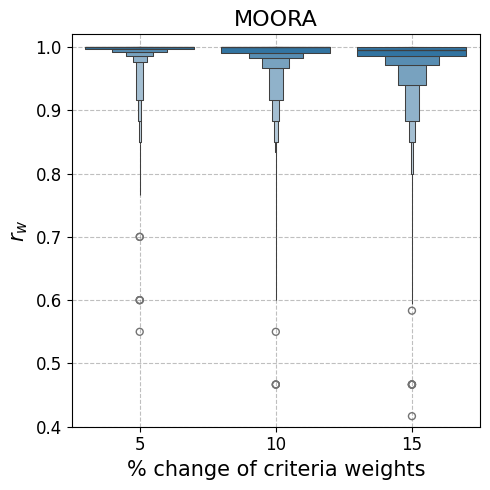

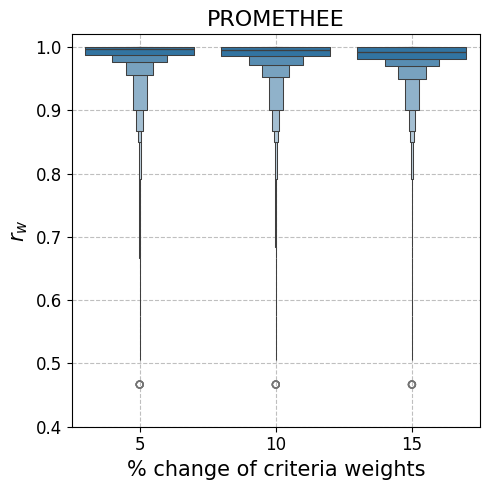

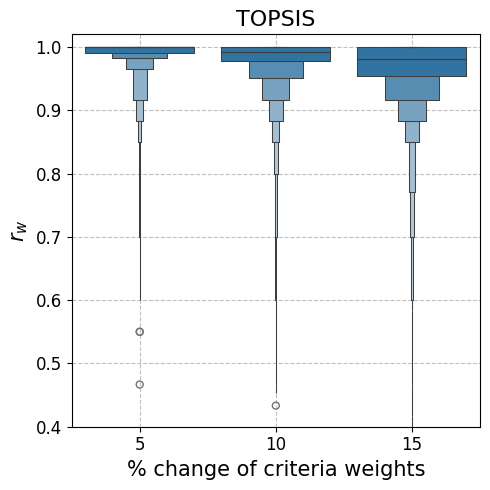

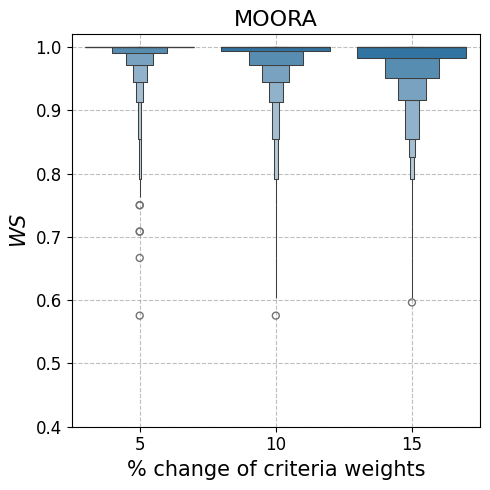

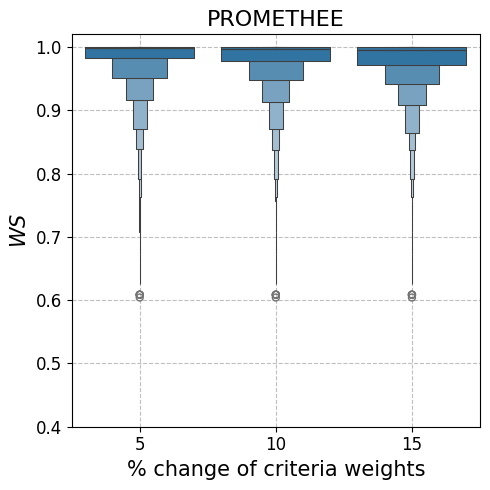

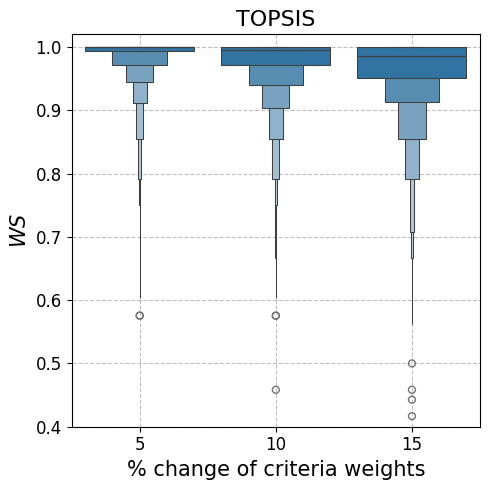

In [40]:
df = exp1_results['modified']
df['% change'] = df['% change'].astype(float)

metrics = ['rw', 'WS']
labels = ['$r_w$', '$WS$']

for metric, label in zip(metrics, labels):
    df[metric] = df[metric].astype(float)

    methods = df['MCDA Method'].unique()
    unique_changes = df['% change'].unique()

    for method in methods:
        method_df = df[df['MCDA Method'] == method]

        g = sns.boxenplot(
            data=method_df,
            x='% change',
            y=metric,
            fill=True,
            cmap='Blues',
        )

        g.set_ylim(0.4, 1.02)
        plt.xticks([0, 1, 2], [5, 10, 15], fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(method, fontsize=16)

        plt.xlabel('% change of criteria weights', fontsize=15)
        plt.ylabel(label, fontsize=15)
        plt.grid(axis='both', linestyle='--', color='grey', alpha=0.5)

        plt.tight_layout()
        plt.savefig(f'img/exp1/{metric}_{method}_boxen.pdf')
        plt.savefig(f'img/exp1/{metric}_{method}_boxen.png')
        plt.show()
        plt.close()

In [41]:
plt.rcParams['axes.axisbelow'] = False
plt.rcParams['figure.figsize'] = (5, 5)

### KDE

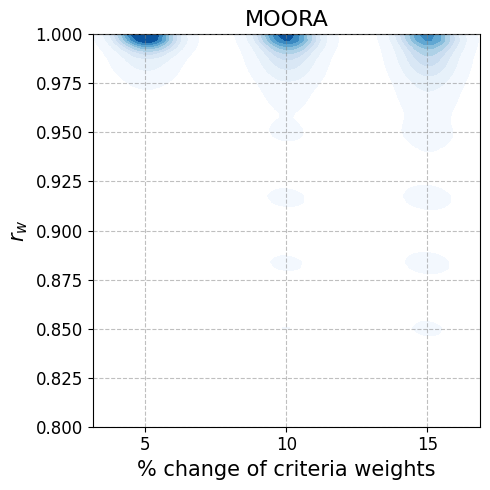

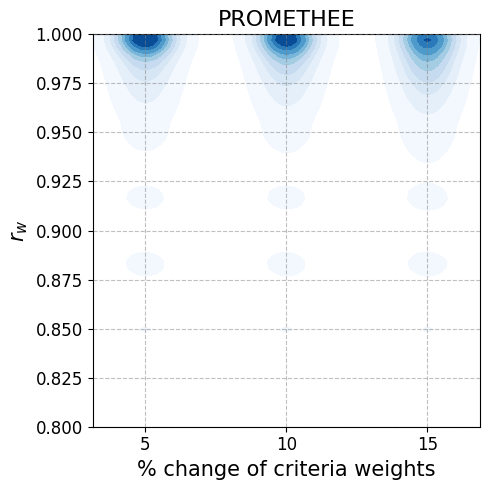

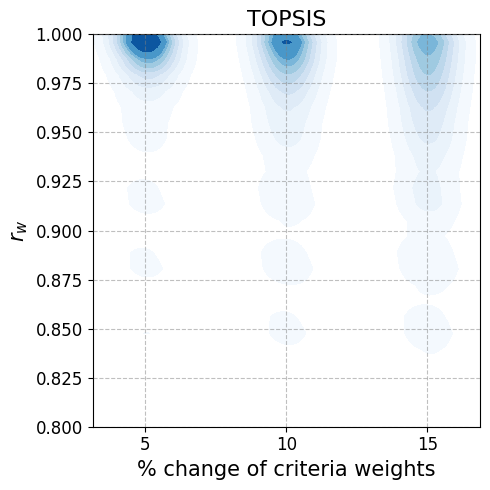

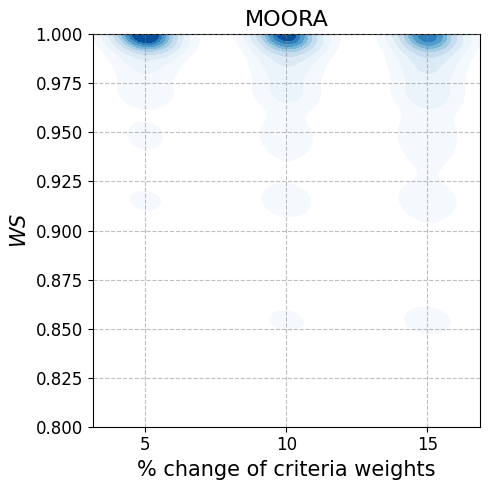

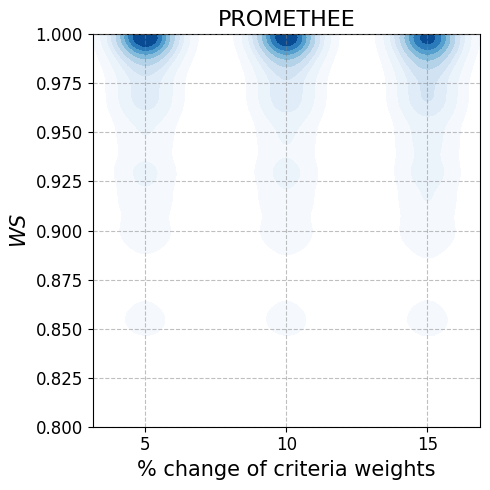

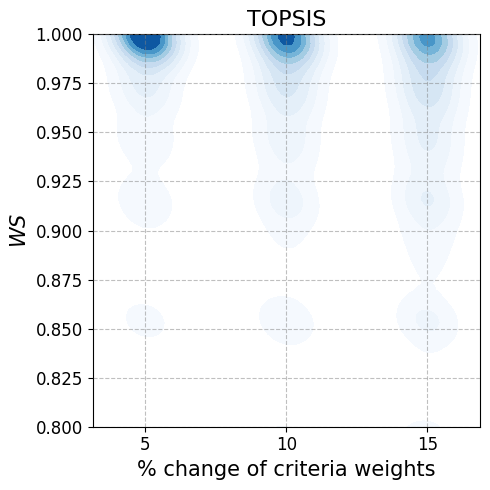

In [42]:
df = exp1_results['modified']
df['% change'] = df['% change'].astype(float)

metrics = ['rw', 'WS']
labels = ['$r_w$', '$WS$']

for metric, label in zip(metrics, labels):
    df[metric] = df[metric].astype(float)

    methods = df['MCDA Method'].unique()
    unique_changes = df['% change'].unique()

    for method in methods:
        method_df = df[df['MCDA Method'] == method]

        g = sns.kdeplot(
            data=method_df,
            x='% change',
            y=metric,
            fill=True,
            cmap='Blues',
        )

        g.set_ylim(0.8, 1)
        plt.xticks([5, 10, 15], fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(method, fontsize=16)

        plt.xlabel('% change of criteria weights', fontsize=15)
        plt.ylabel(label, fontsize=15)
        plt.grid(axis='both', linestyle='--', color='grey', alpha=0.5)

        plt.tight_layout()
        plt.savefig(f'img/exp1/{metric}_{method}_kde.pdf')
        plt.savefig(f'img/exp1/{metric}_{method}_kde.png')
        plt.show()
        plt.close()

### Boxenplot for all methods in one plot

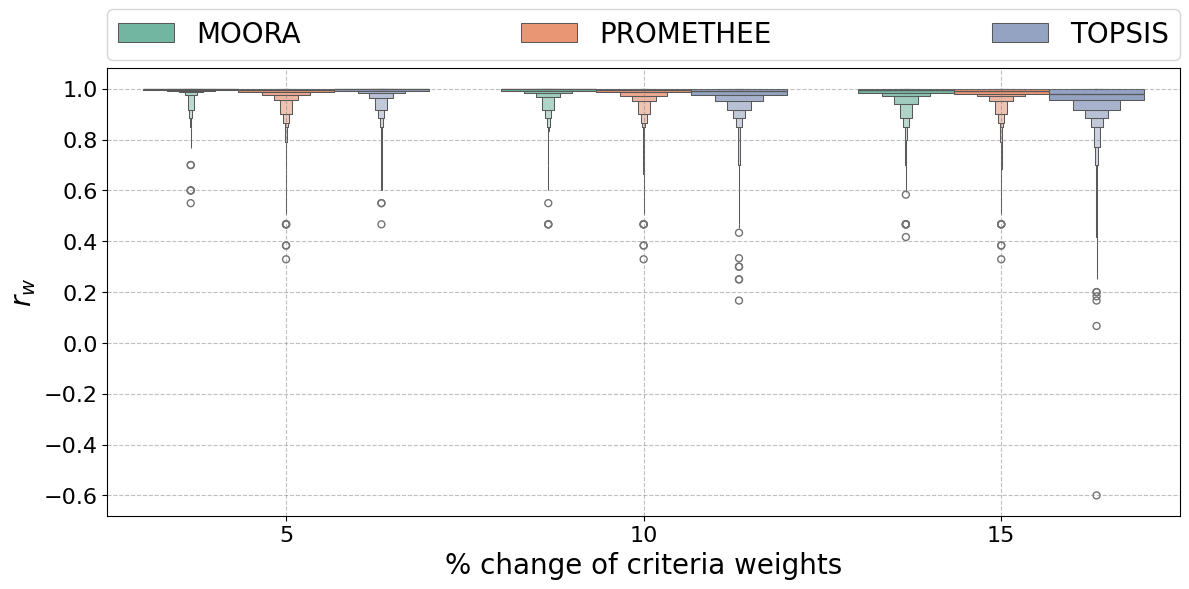

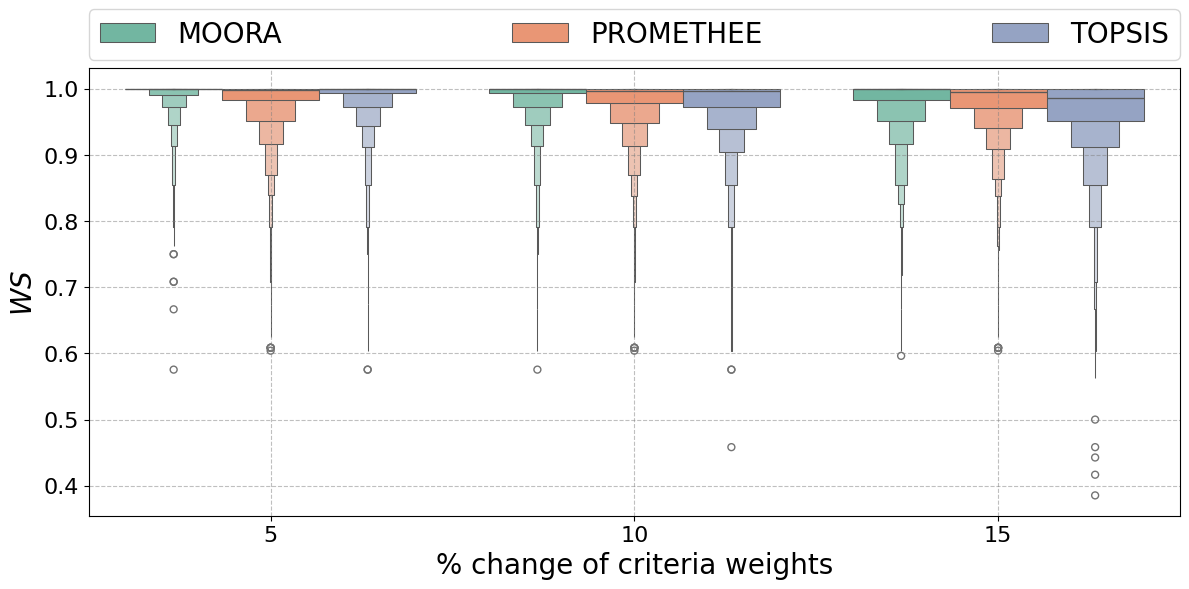

In [26]:
plt.rcParams['figure.figsize'] = (12, 6)

df = exp1_results['modified']
df['% change'] = df['% change'].astype(float)

metrics = ['rw', 'WS']
labels = ['$r_w$', '$WS$']

for metric, label in zip(metrics, labels):
    sns.boxenplot(
        data=df,
        x='% change',
        y=metric,
        palette='Set2',
        hue='MCDA Method'
    )

    plt.xlabel('% change of criteria weights', fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.xticks([0, 1, 2], [5, 10, 15], fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(axis='both', linestyle='--', color='grey', alpha=0.5)
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, fontsize=20)
    plt.tight_layout()
    plt.savefig(f'img/exp1/{metric}_methods_boxen.pdf')
    plt.savefig(f'img/exp1/{metric}_methods_boxen.png')
    plt.show()
    plt.close()

### Boxenplot for different dimensionalities in simulation runs

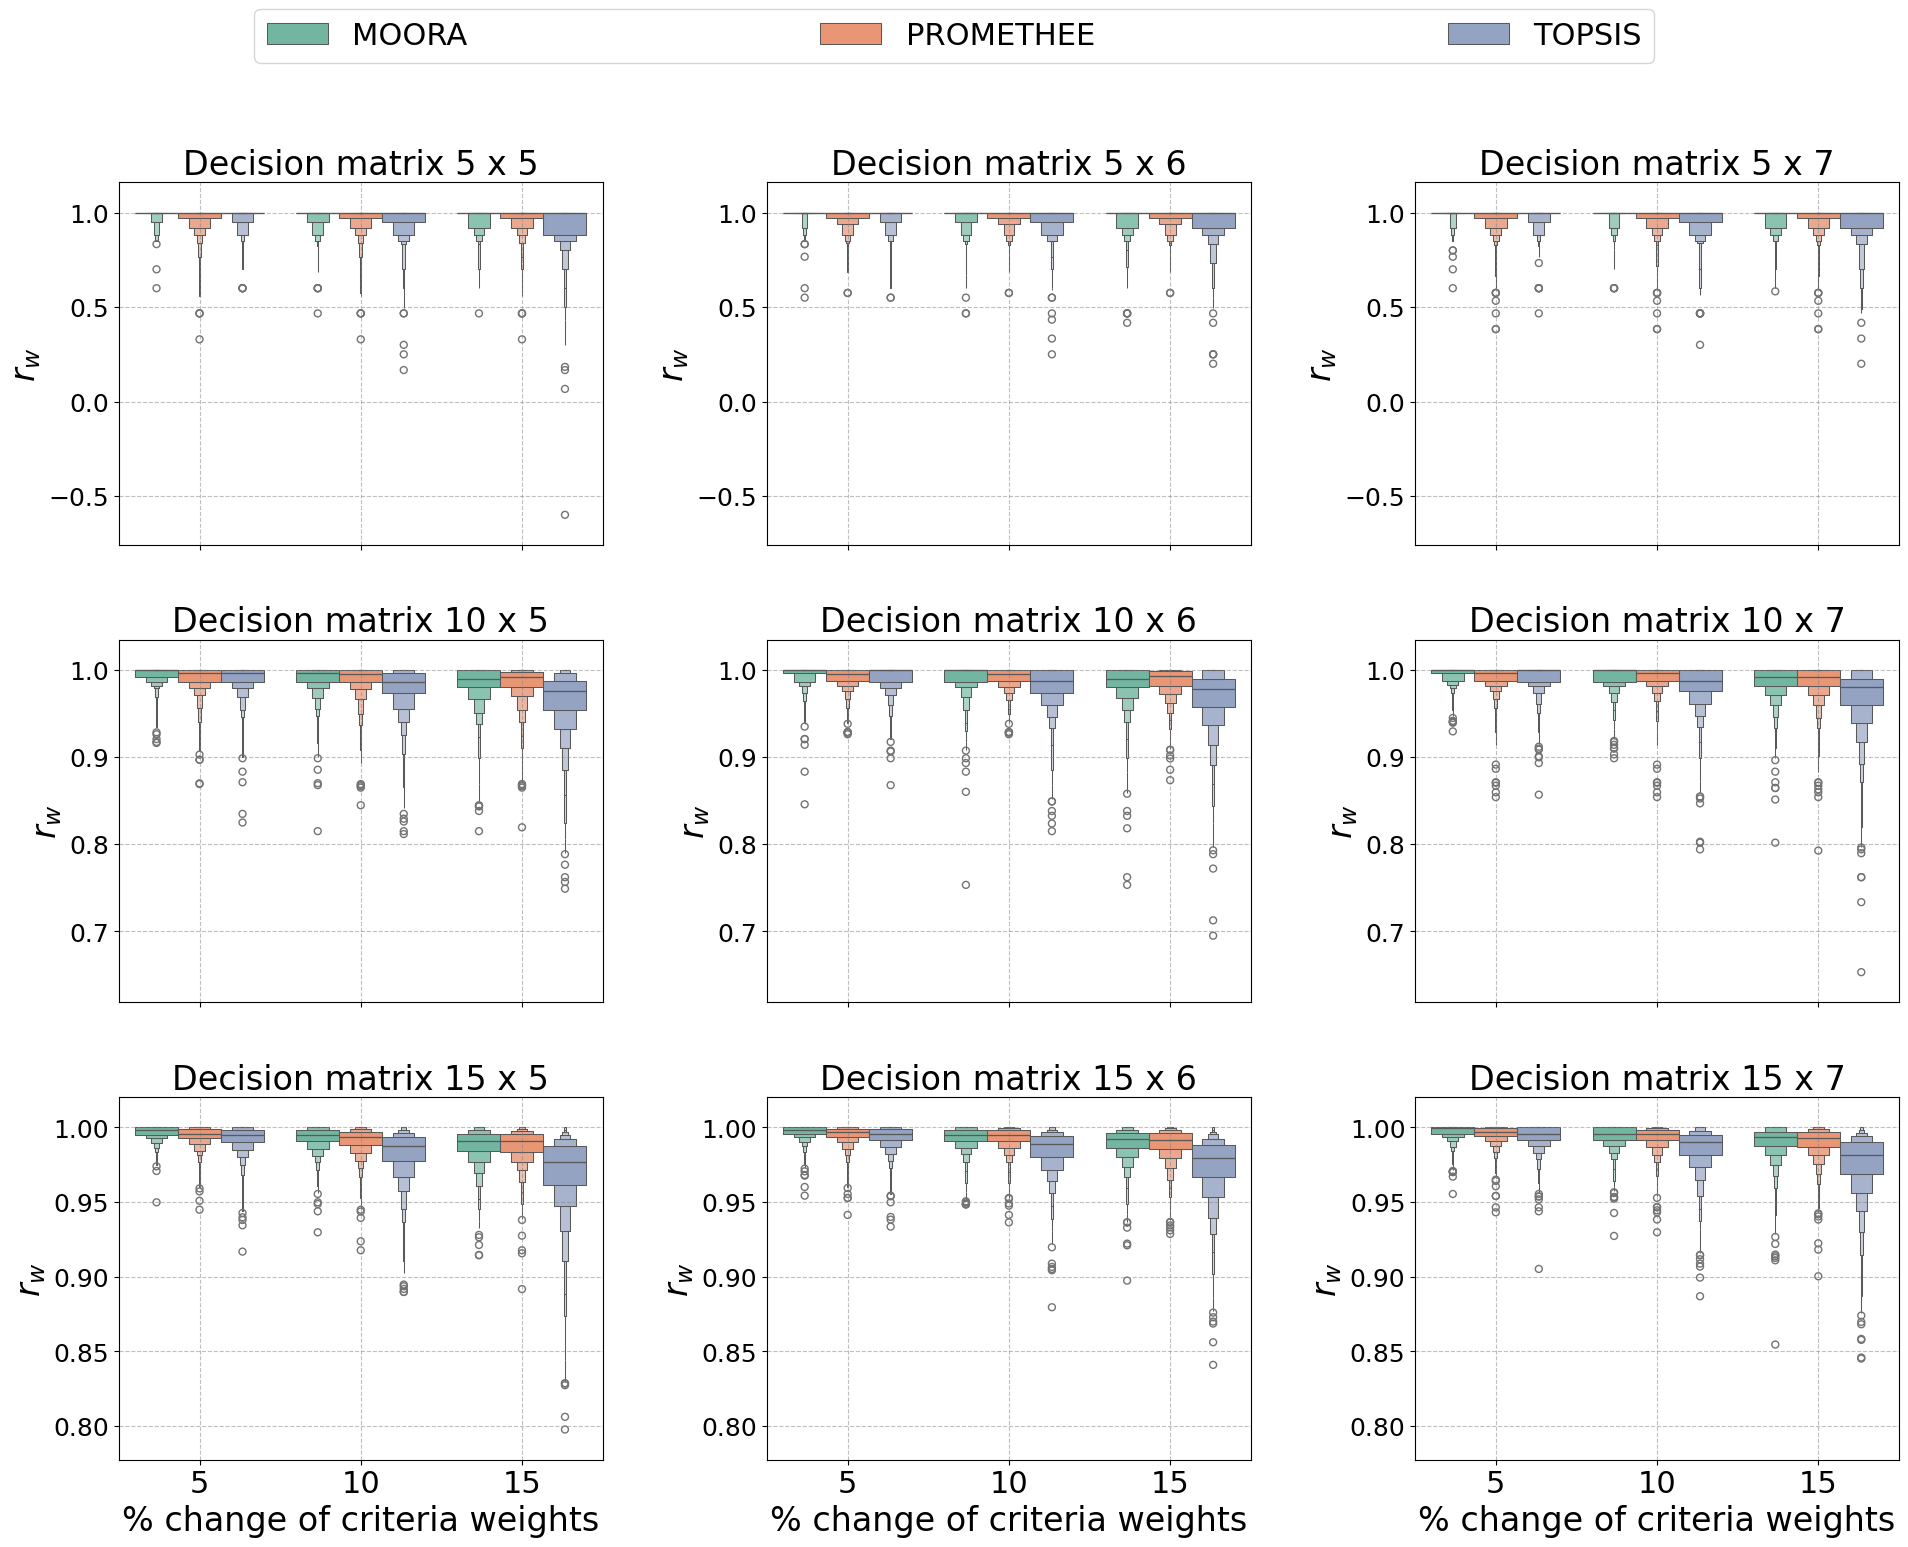

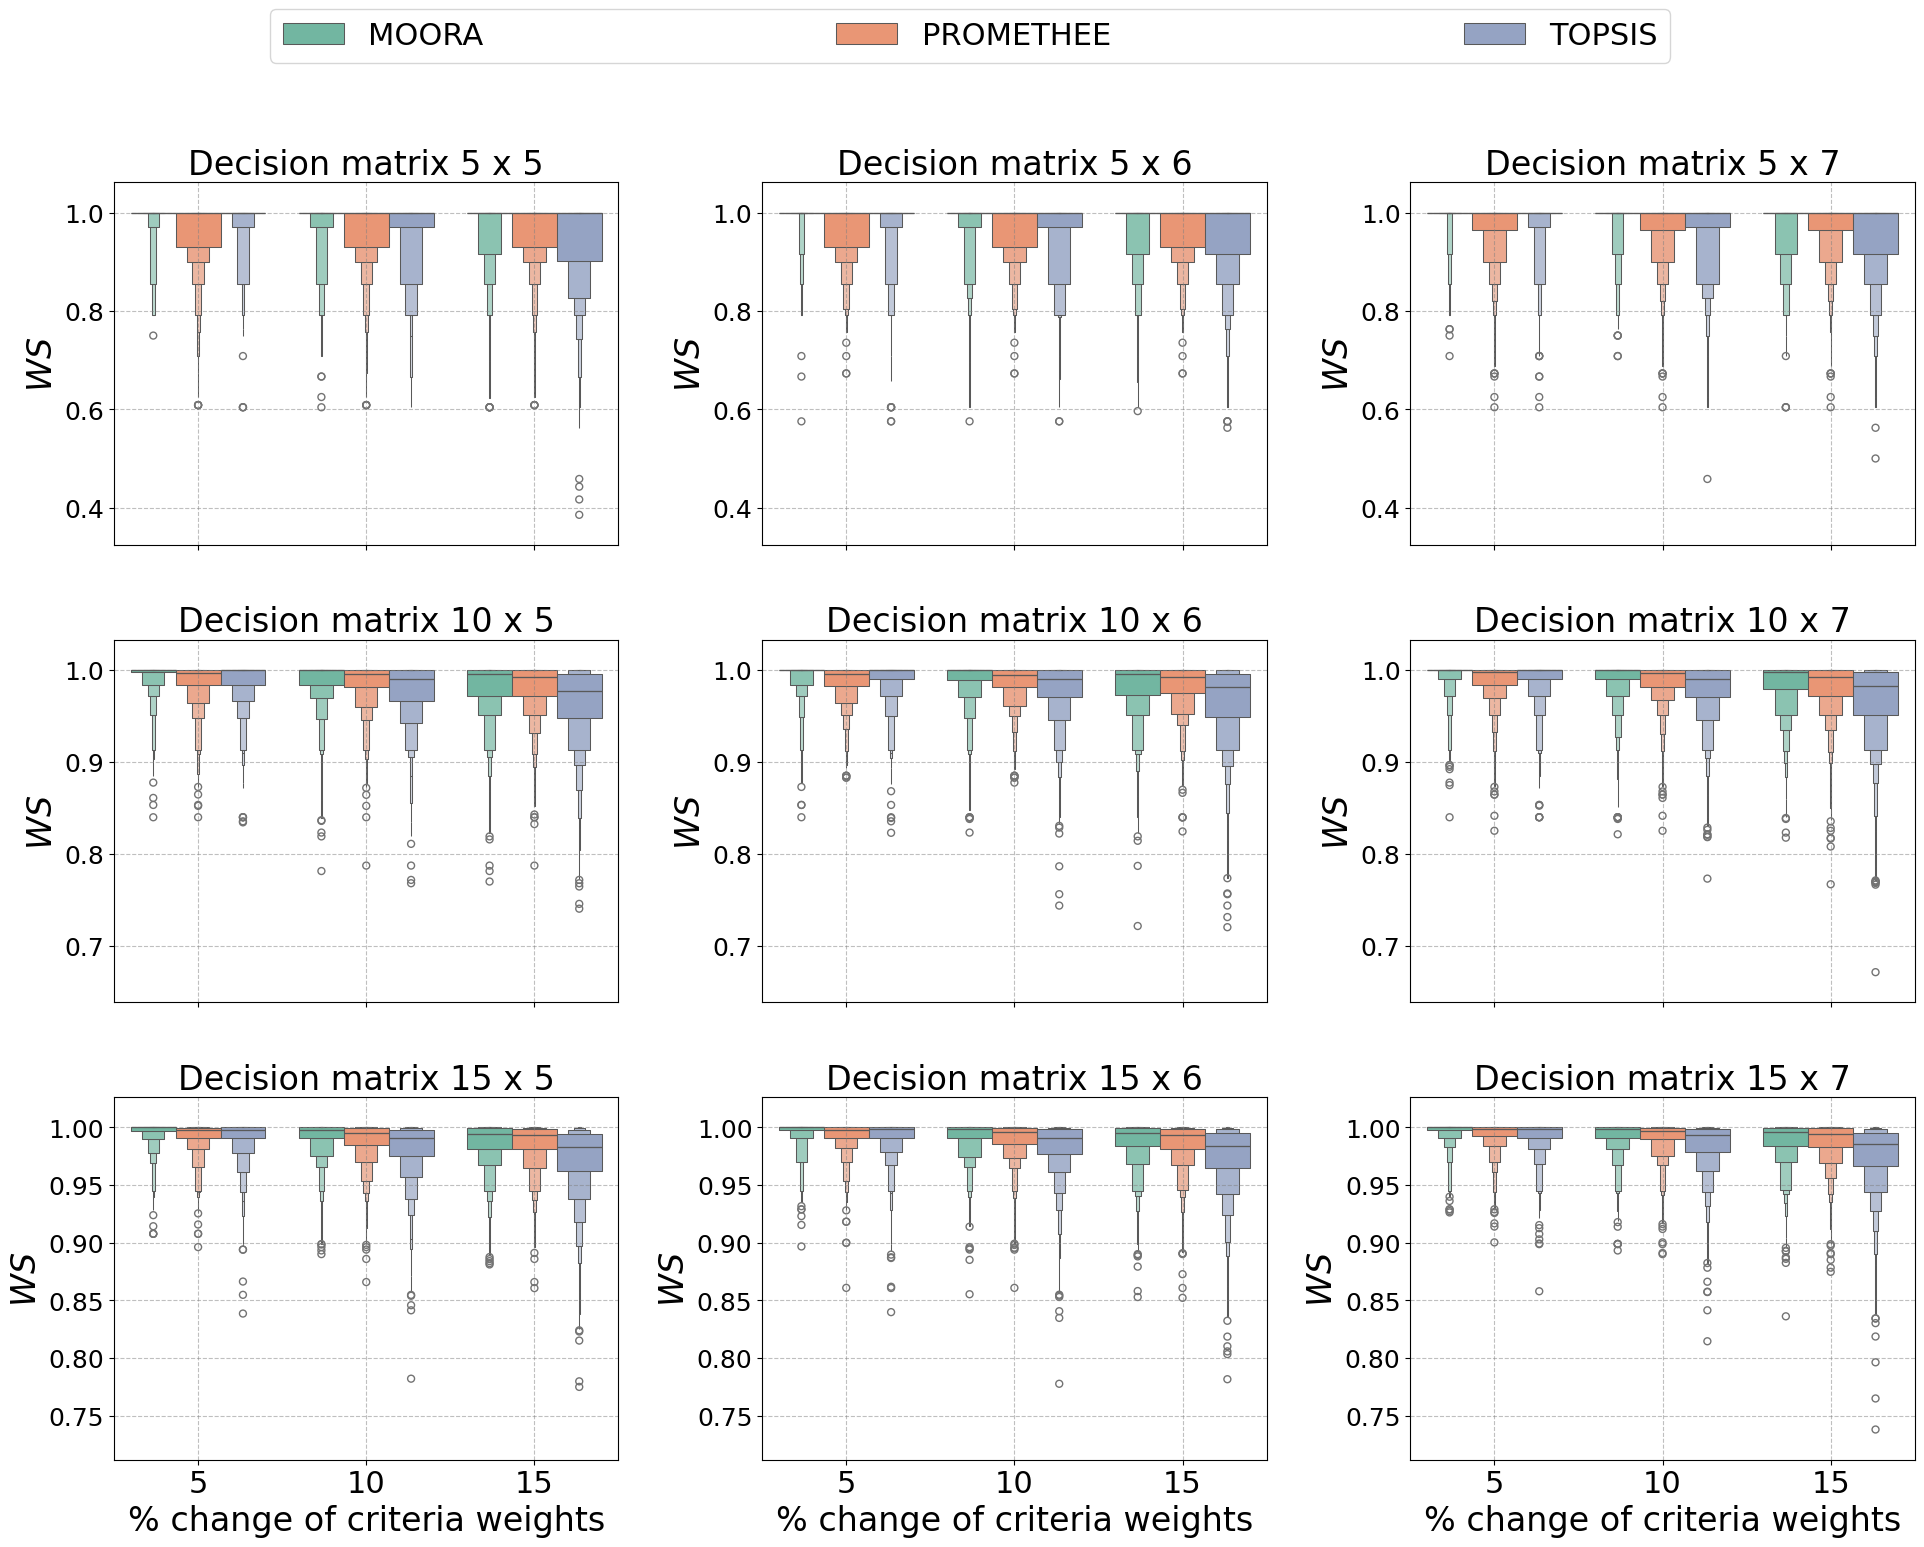

In [31]:
unique_alternatives = df['Alternatives'].unique()
unique_criteria = df['Criteria'].unique()

metrics = ['rw', 'WS']
labels = ['$r_w$', '$WS$']

for metric, label in zip(metrics, labels):
    fig, axes = plt.subplots(
        len(unique_alternatives), len(unique_criteria),
        figsize=(20, 15),
        sharex=True, sharey=False
    )


    for i, alt in enumerate(unique_alternatives):
        for j, crit in enumerate(unique_criteria):
            subset = df[(df['Alternatives'] == alt) & (df['Criteria'] == crit)]

            ax = axes[i, j]
            sns.boxenplot(
                data=subset,
                x='% change',
                y=metric,
                hue='MCDA Method',
                palette='Set2',
                ax=ax
            )

            ax.set_title(f'Decision matrix {alt} x {crit}', fontsize=24)
            ax.set_xlabel('% change of criteria weights', fontsize=24)
            ax.set_xticks([0, 1, 2])
            ax.set_xticklabels([5, 10, 15], fontsize=22)
            ax.set_ylabel(label, fontsize=24)

            ax.tick_params(axis='y', labelsize=18)
            ax.legend_.remove()

            ax.grid(axis='both', linestyle='--', color='grey', alpha=0.5)
        
        row_data = df[df['Alternatives'] == alt][metric]
        y_min, y_max = row_data.min(), row_data.max()
        y_padding = (y_max - y_min) * 0.1 
        for ax in axes[i]:
            ax.set_ylim(y_min - y_padding, y_max + y_padding)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0.15, 1.02, 0.7, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, fontsize=22)

    plt.tight_layout(pad=4.0)
    plt.savefig(f'img/exp1/{metric}_grid_boxen.pdf', bbox_inches='tight')
    plt.savefig(f'img/exp1/{metric}_grid_boxen.png')
    plt.show()
    plt.close()

## Experiment 2

### KDE plot with distributions of removed criteria count and correlation coefficients

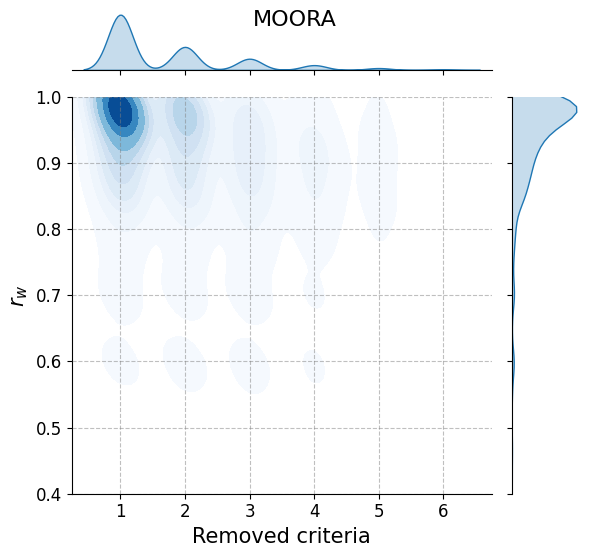

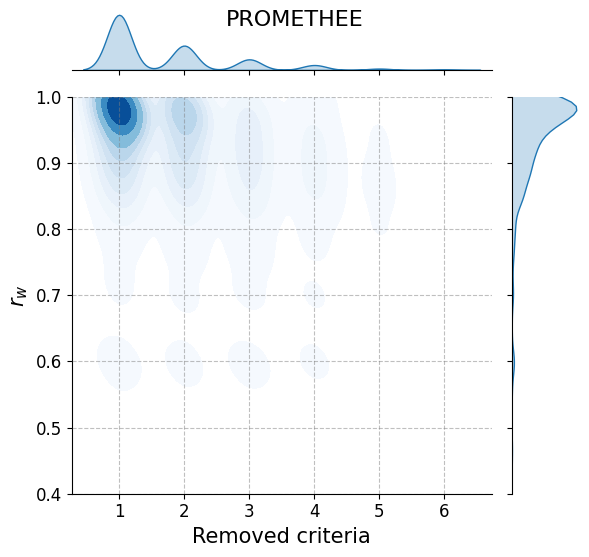

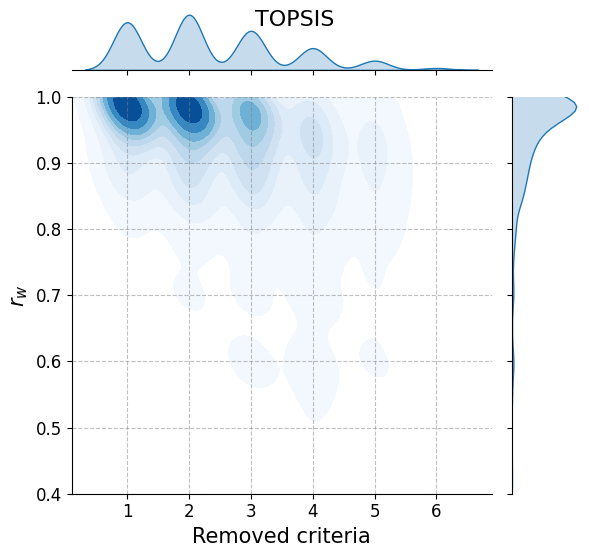

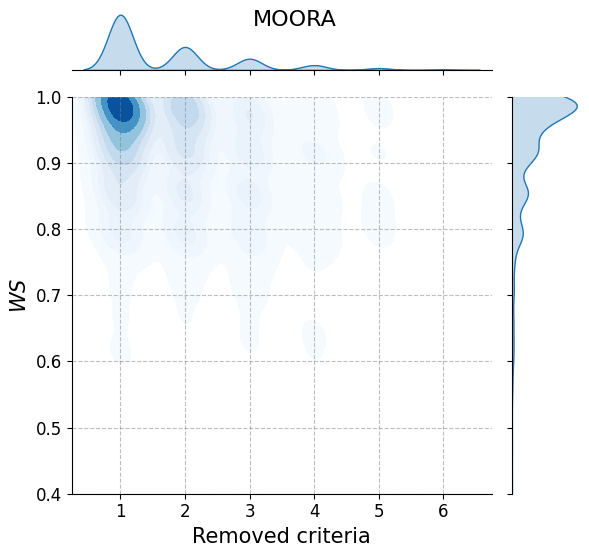

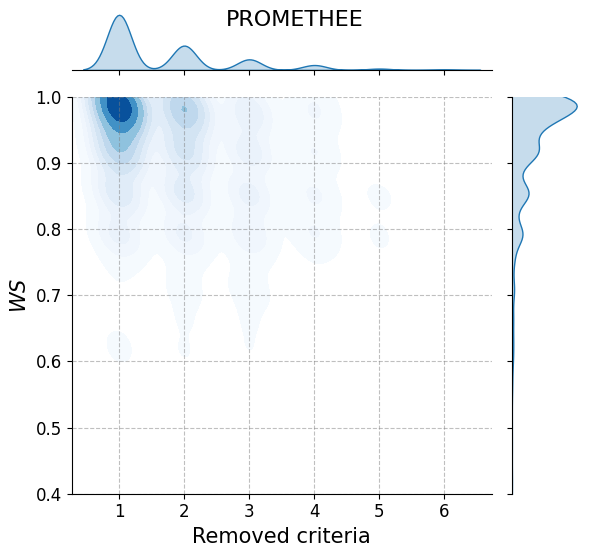

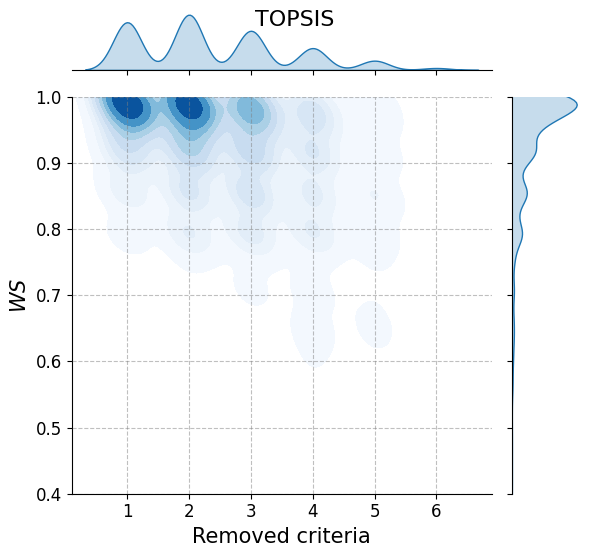

In [55]:
df = exp2_results['modified']

metrics = ['rw', 'WS']
labels = ['$r_w$', '$WS$']

for metric, label in zip(metrics, labels):
    df[metric] = df[metric].astype(float)

    methods = df['MCDA Method'].unique()

    for method in methods:
        method_df = df[df['MCDA Method'] == method]

        g = sns.jointplot(
            data=method_df,
            x='Removed criteria',
            y=metric,
            kind='kde',
            fill=True,
            cmap='Blues'
        )
        g.ax_joint.set_ylim(0.40, 1)
        g.fig.suptitle(f'{method}', y=0.92, fontsize=16)

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        plt.xlabel('Removed criteria', fontsize=15)
        plt.ylabel(label, fontsize=15)
        plt.grid(axis='both', linestyle='--', color='grey', alpha=0.5)

        plt.tight_layout()
        plt.savefig(f'img/exp2/{metric}_{method}_asc_kde.pdf')
        plt.savefig(f'img/exp2/{metric}_{method}_asc_kde.png')
        plt.show()
        plt.close()

### Boxenplot for different dimensionalities in simulation runs

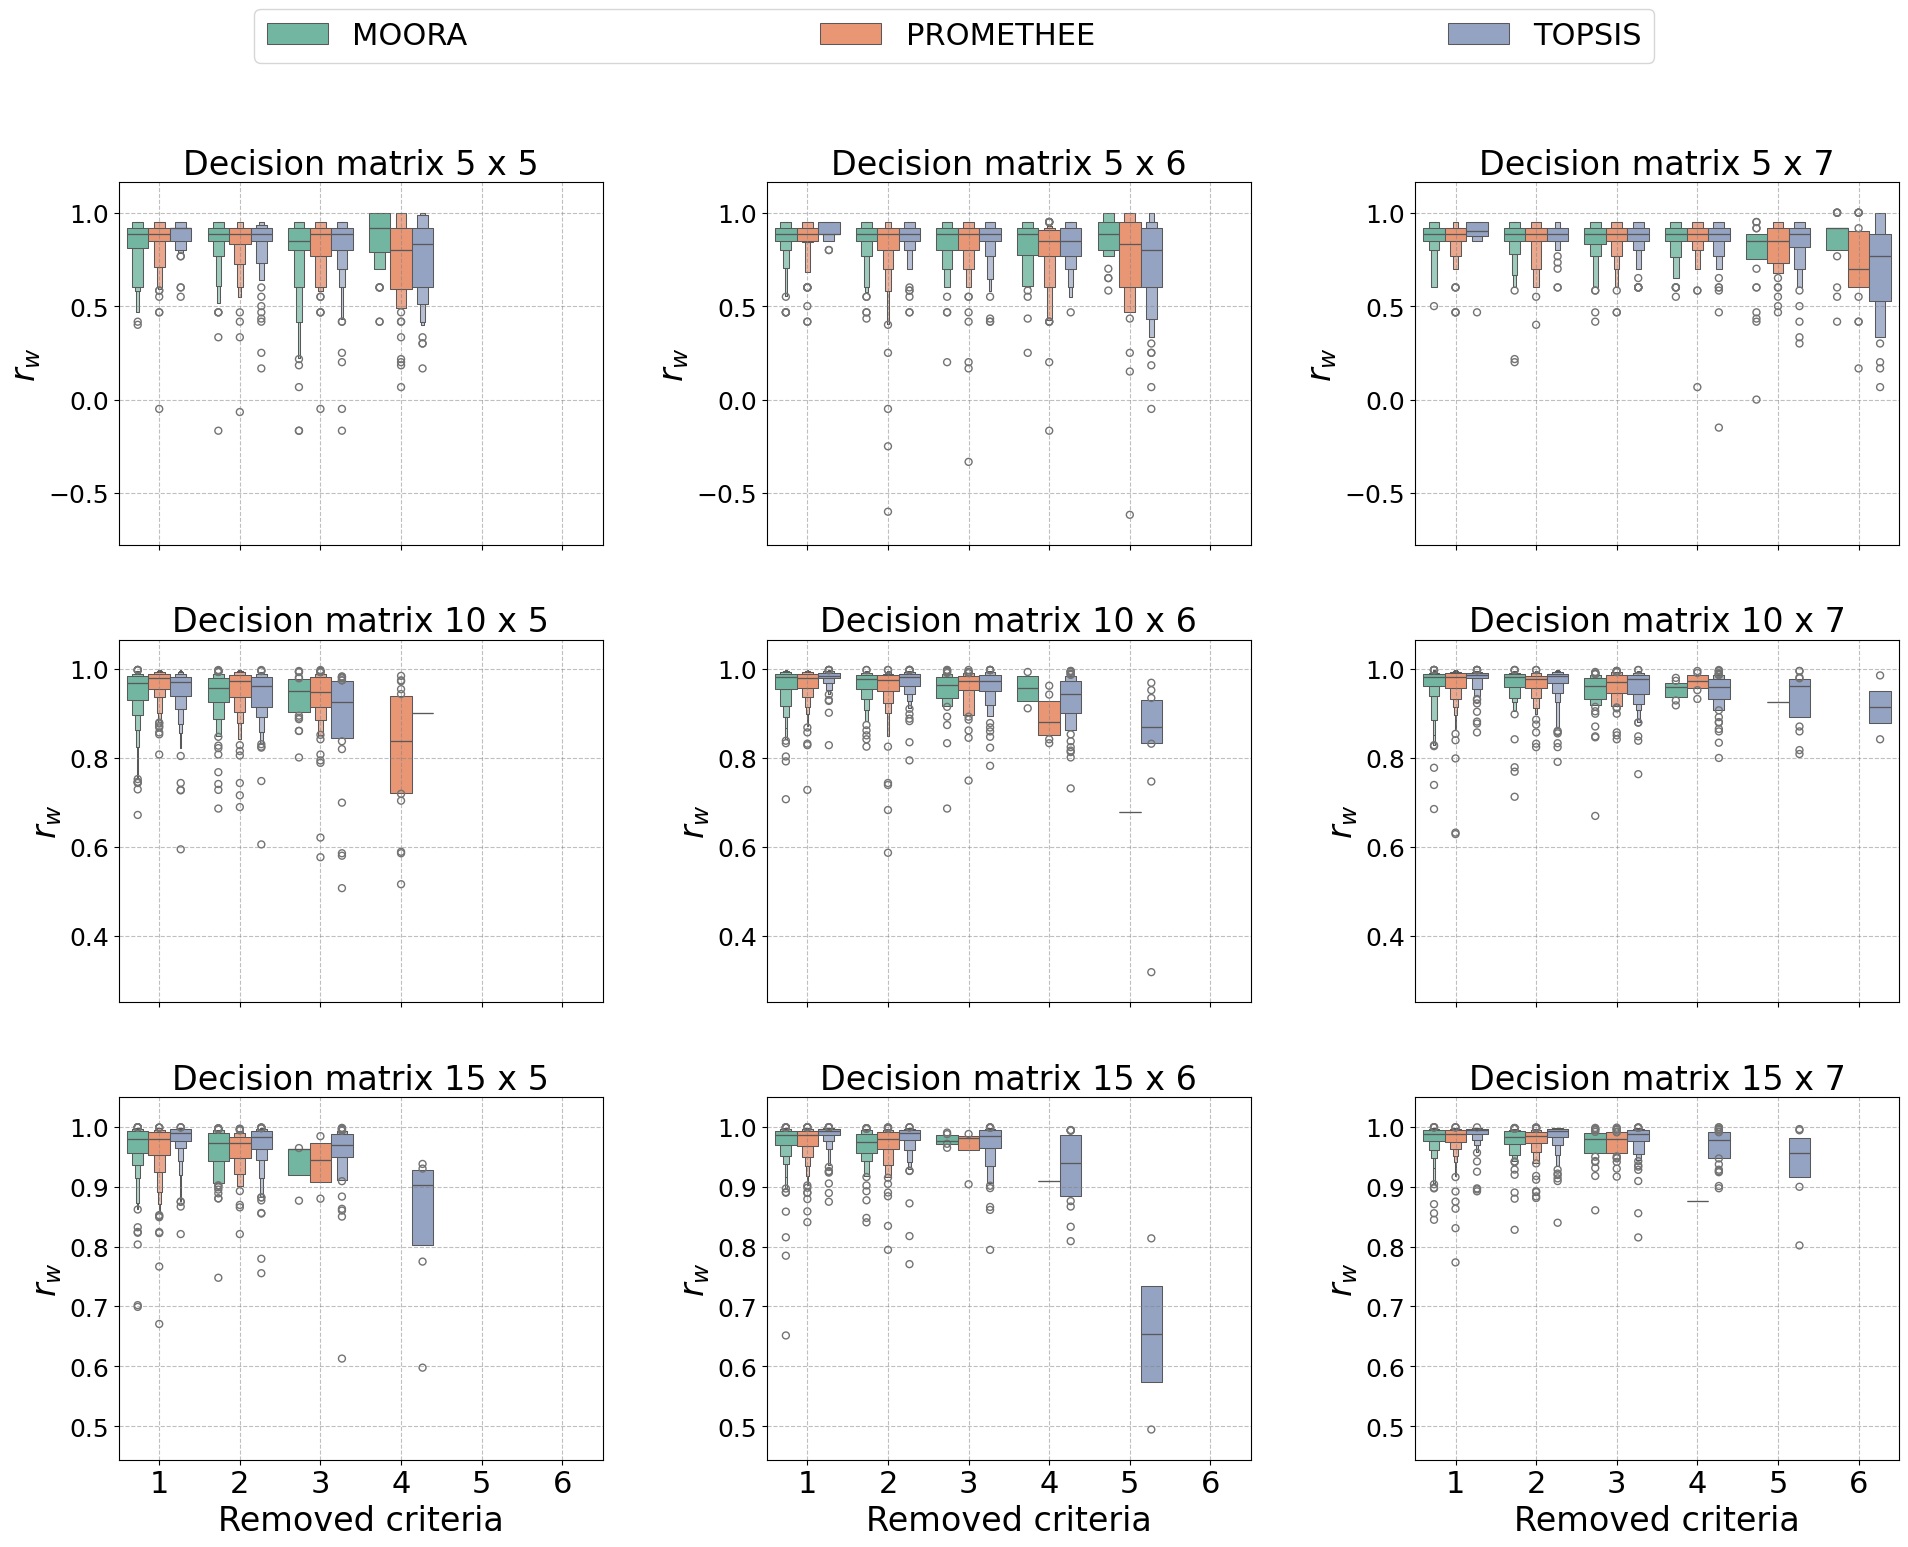

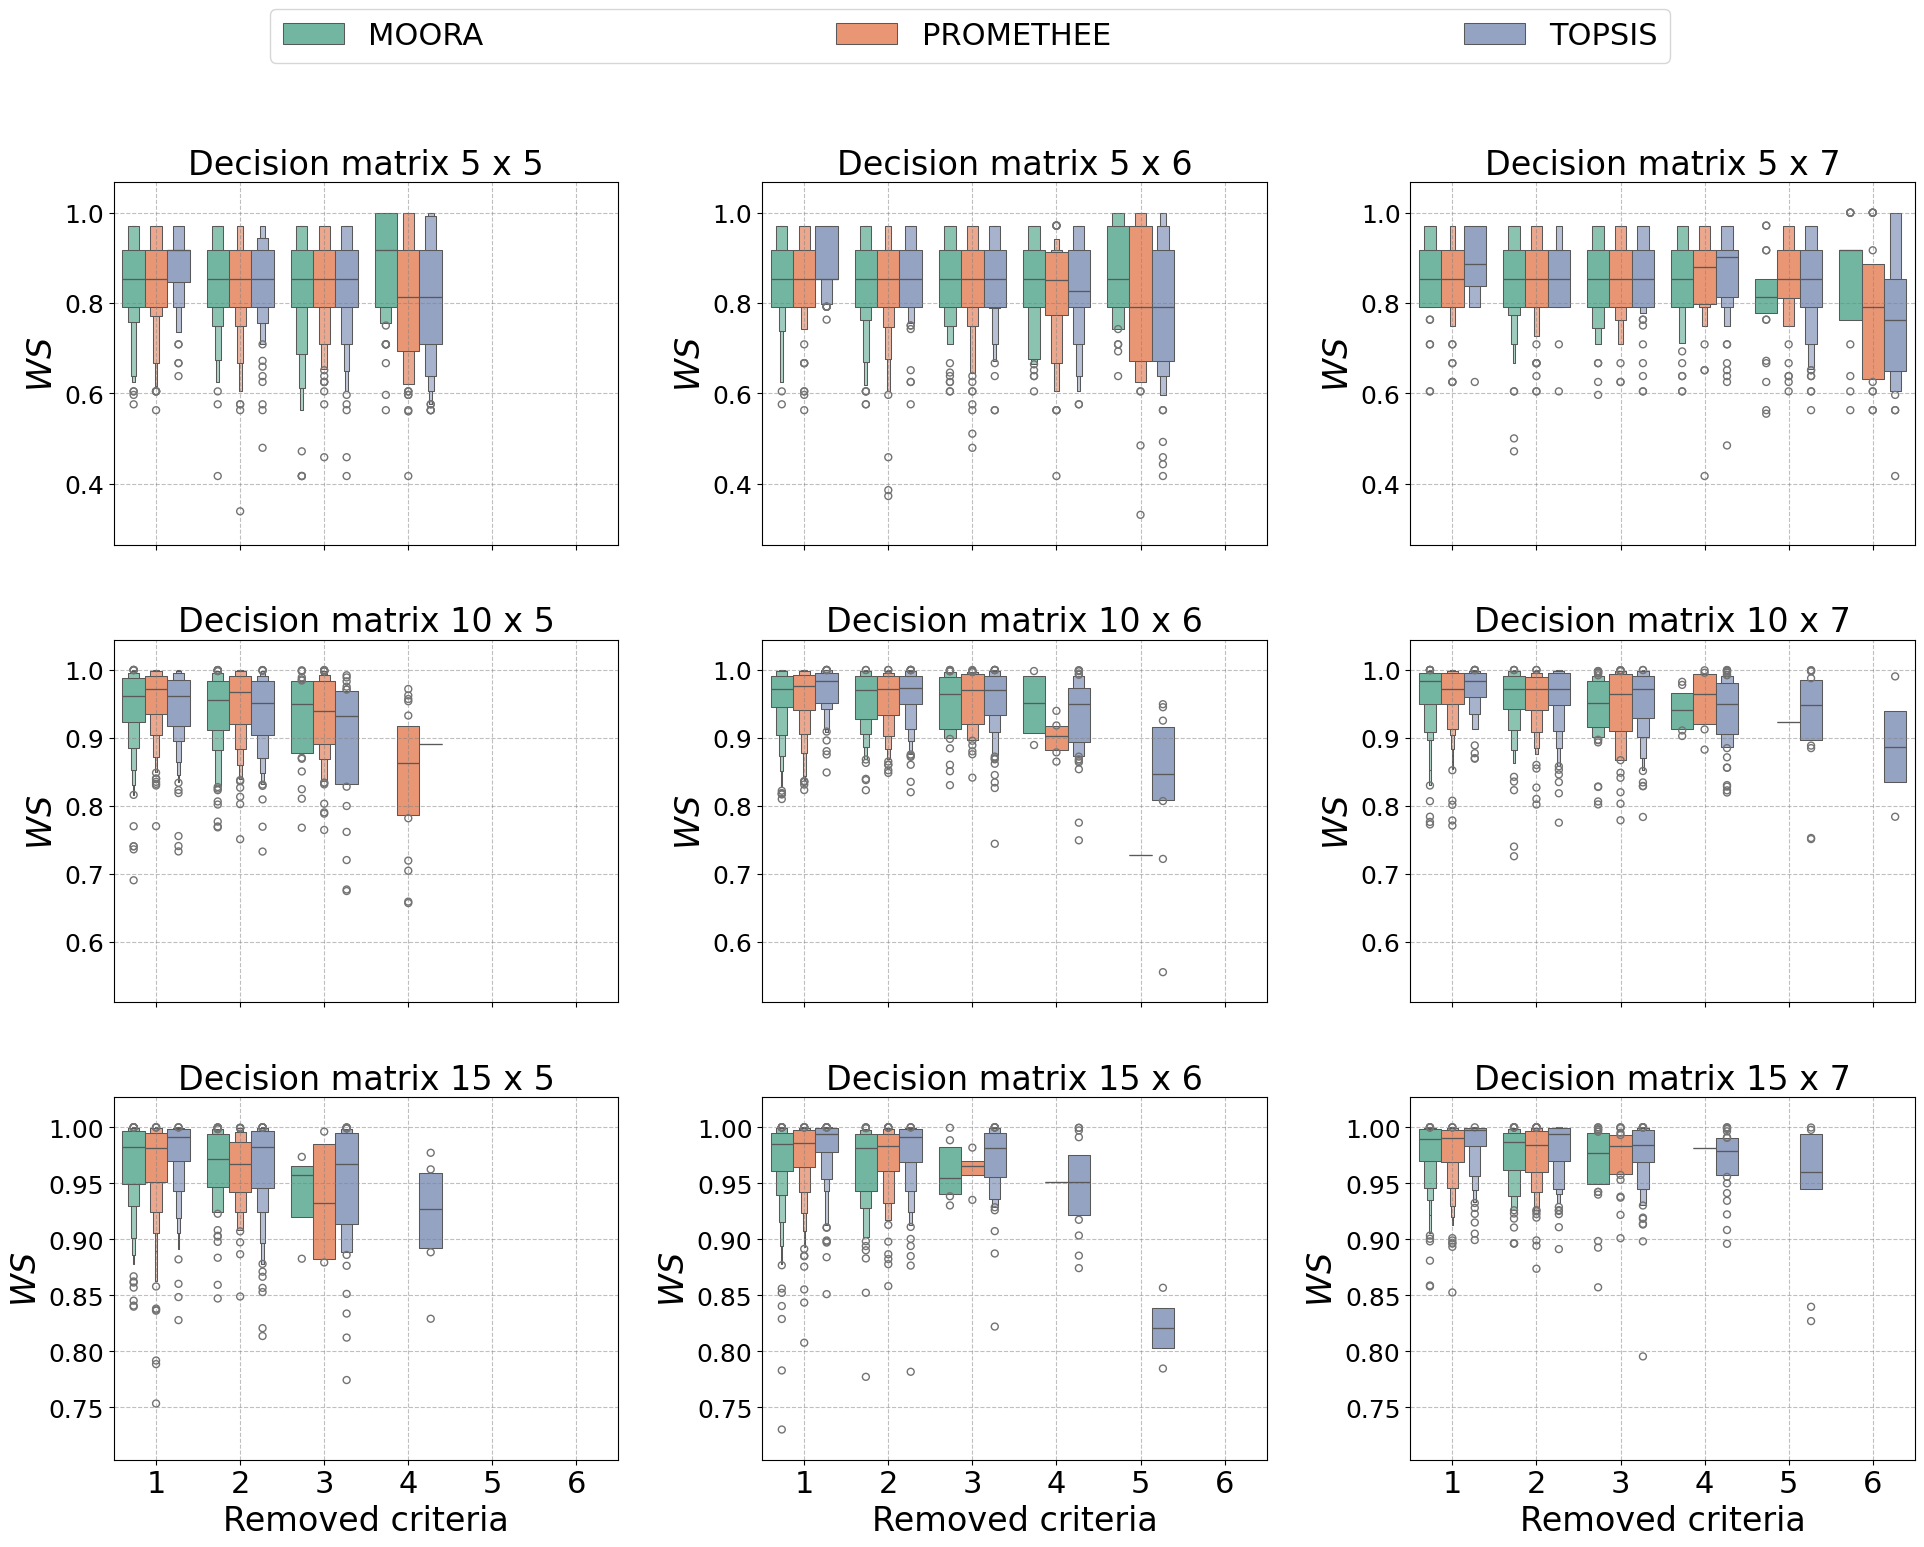

In [33]:
df = exp2_results['modified']

unique_alternatives = df['Alternatives'].unique()
unique_criteria = df['Criteria'].unique()

metrics = ['rw', 'WS']
labels = ['$r_w$', '$WS$']

for metric, label in zip(metrics, labels):
    fig, axes = plt.subplots(
        len(unique_alternatives), len(unique_criteria),
        figsize=(20, 15),
        sharex=True, sharey=False
    )


    for i, alt in enumerate(unique_alternatives):
        for j, crit in enumerate(unique_criteria):
            subset = df[(df['Alternatives'] == alt) & (df['Criteria'] == crit)]

            ax = axes[i, j]
            sns.boxenplot(
                data=subset,
                x='Removed criteria',
                y=metric,
                hue='MCDA Method',
                palette='Set2',
                ax=ax
            )

            ax.set_title(f'Decision matrix {alt} x {crit}', fontsize=24)
            ax.set_xlabel('Removed criteria', fontsize=24)
            ax.set_ylabel(label, fontsize=24)

            ax.tick_params(axis='y', labelsize=18)
            ax.tick_params(axis='x', labelsize=22)
            ax.legend_.remove()

            ax.grid(axis='both', linestyle='--', color='grey', alpha=0.5)
        
        row_data = df[df['Alternatives'] == alt][metric]
        y_min, y_max = row_data.min(), row_data.max()
        y_padding = (y_max - y_min) * 0.1 
        for ax in axes[i]:
            ax.set_ylim(y_min - y_padding, y_max + y_padding)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0.15, 1.02, 0.7, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, fontsize=22)

    plt.tight_layout(pad=4.0)
    plt.savefig(f'img/exp2/{metric}_grid_asc_boxen.pdf', bbox_inches='tight')
    plt.savefig(f'img/exp2/{metric}_grid_asc_boxen.png')
    plt.show()
    plt.close()

## Experiment 3

### KDE plot with distributions of modification of values in decision matrix and correlation coefficients

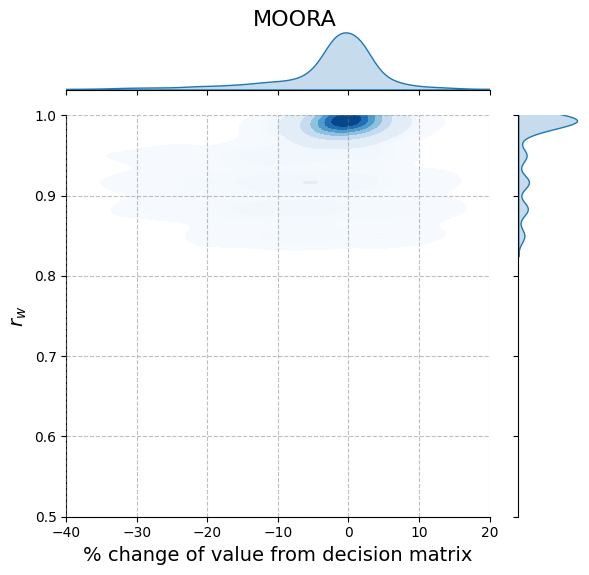

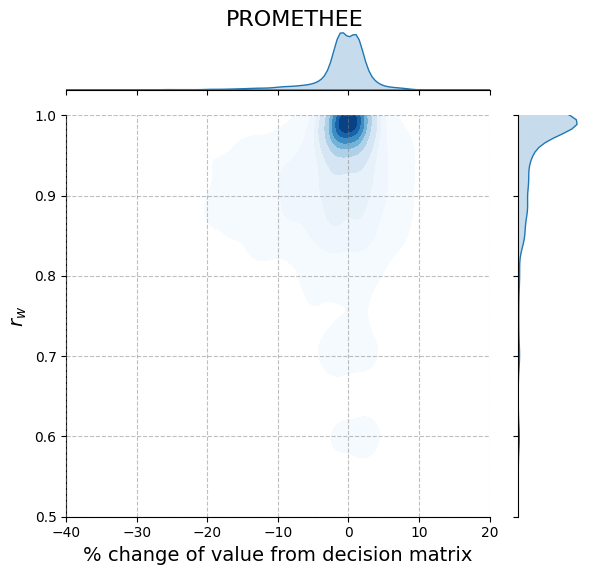

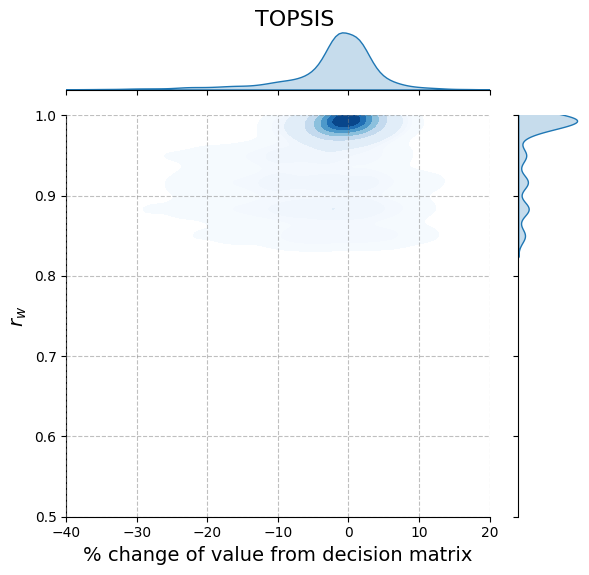

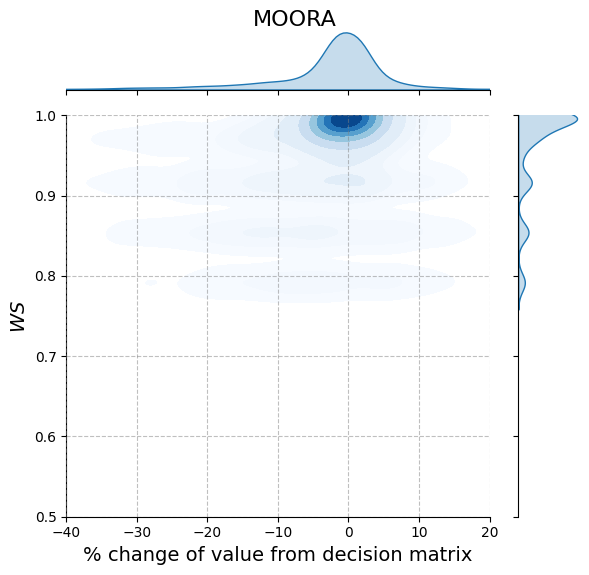

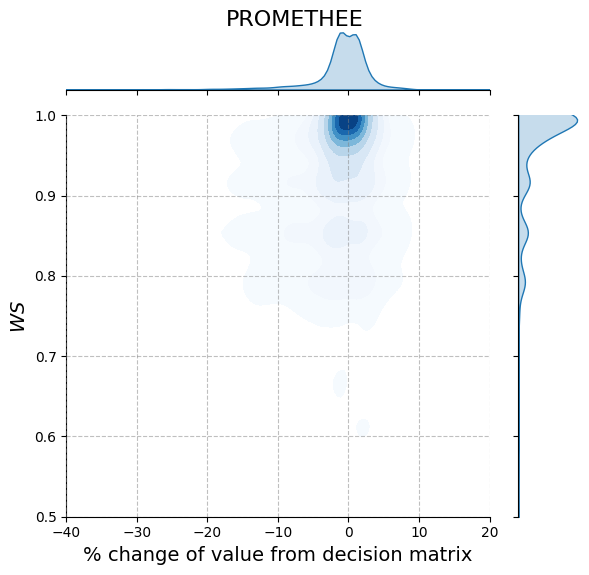

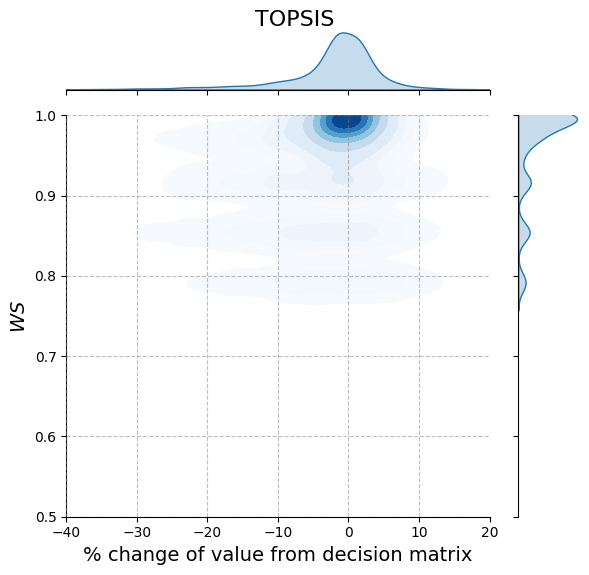

In [60]:
df = exp3_results['modified_global']

df['% change'] = df['% change'].astype(float)
df['rw'] = df['rw'].astype(float)

metrics = ['rw', 'WS']
labels = ['$r_w$', '$WS$']
methods = df['MCDA Method'].unique()

for metric, label in zip(metrics, labels):

    for method in methods:
        method_df = df[df['MCDA Method'] == method]

        g = sns.jointplot(
            data=method_df,
            x='% change',
            y=metric,
            kind='kde',
            fill=True,
            cmap='Blues',
        )
        g.fig.suptitle(f'{method}', y=0.95, fontsize=16)

        plt.ylim([0.5, 1])
        plt.xlim([-40, 20])
        plt.ylabel(label, fontsize=14)
        plt.xlabel('% change of value from decision matrix', fontsize=14)
        plt.grid(axis='both', linestyle='--', alpha=0.5, color='grey')
        plt.tight_layout()
        plt.savefig(f'img/exp3/exp_3_{metric}_{method}_kde.pdf')
        plt.savefig(f'img/exp3/exp_3{metric}_{method}_kde.png')
        plt.show()
        plt.close()

### Scatterplot for different dimensionalities in simulation runs

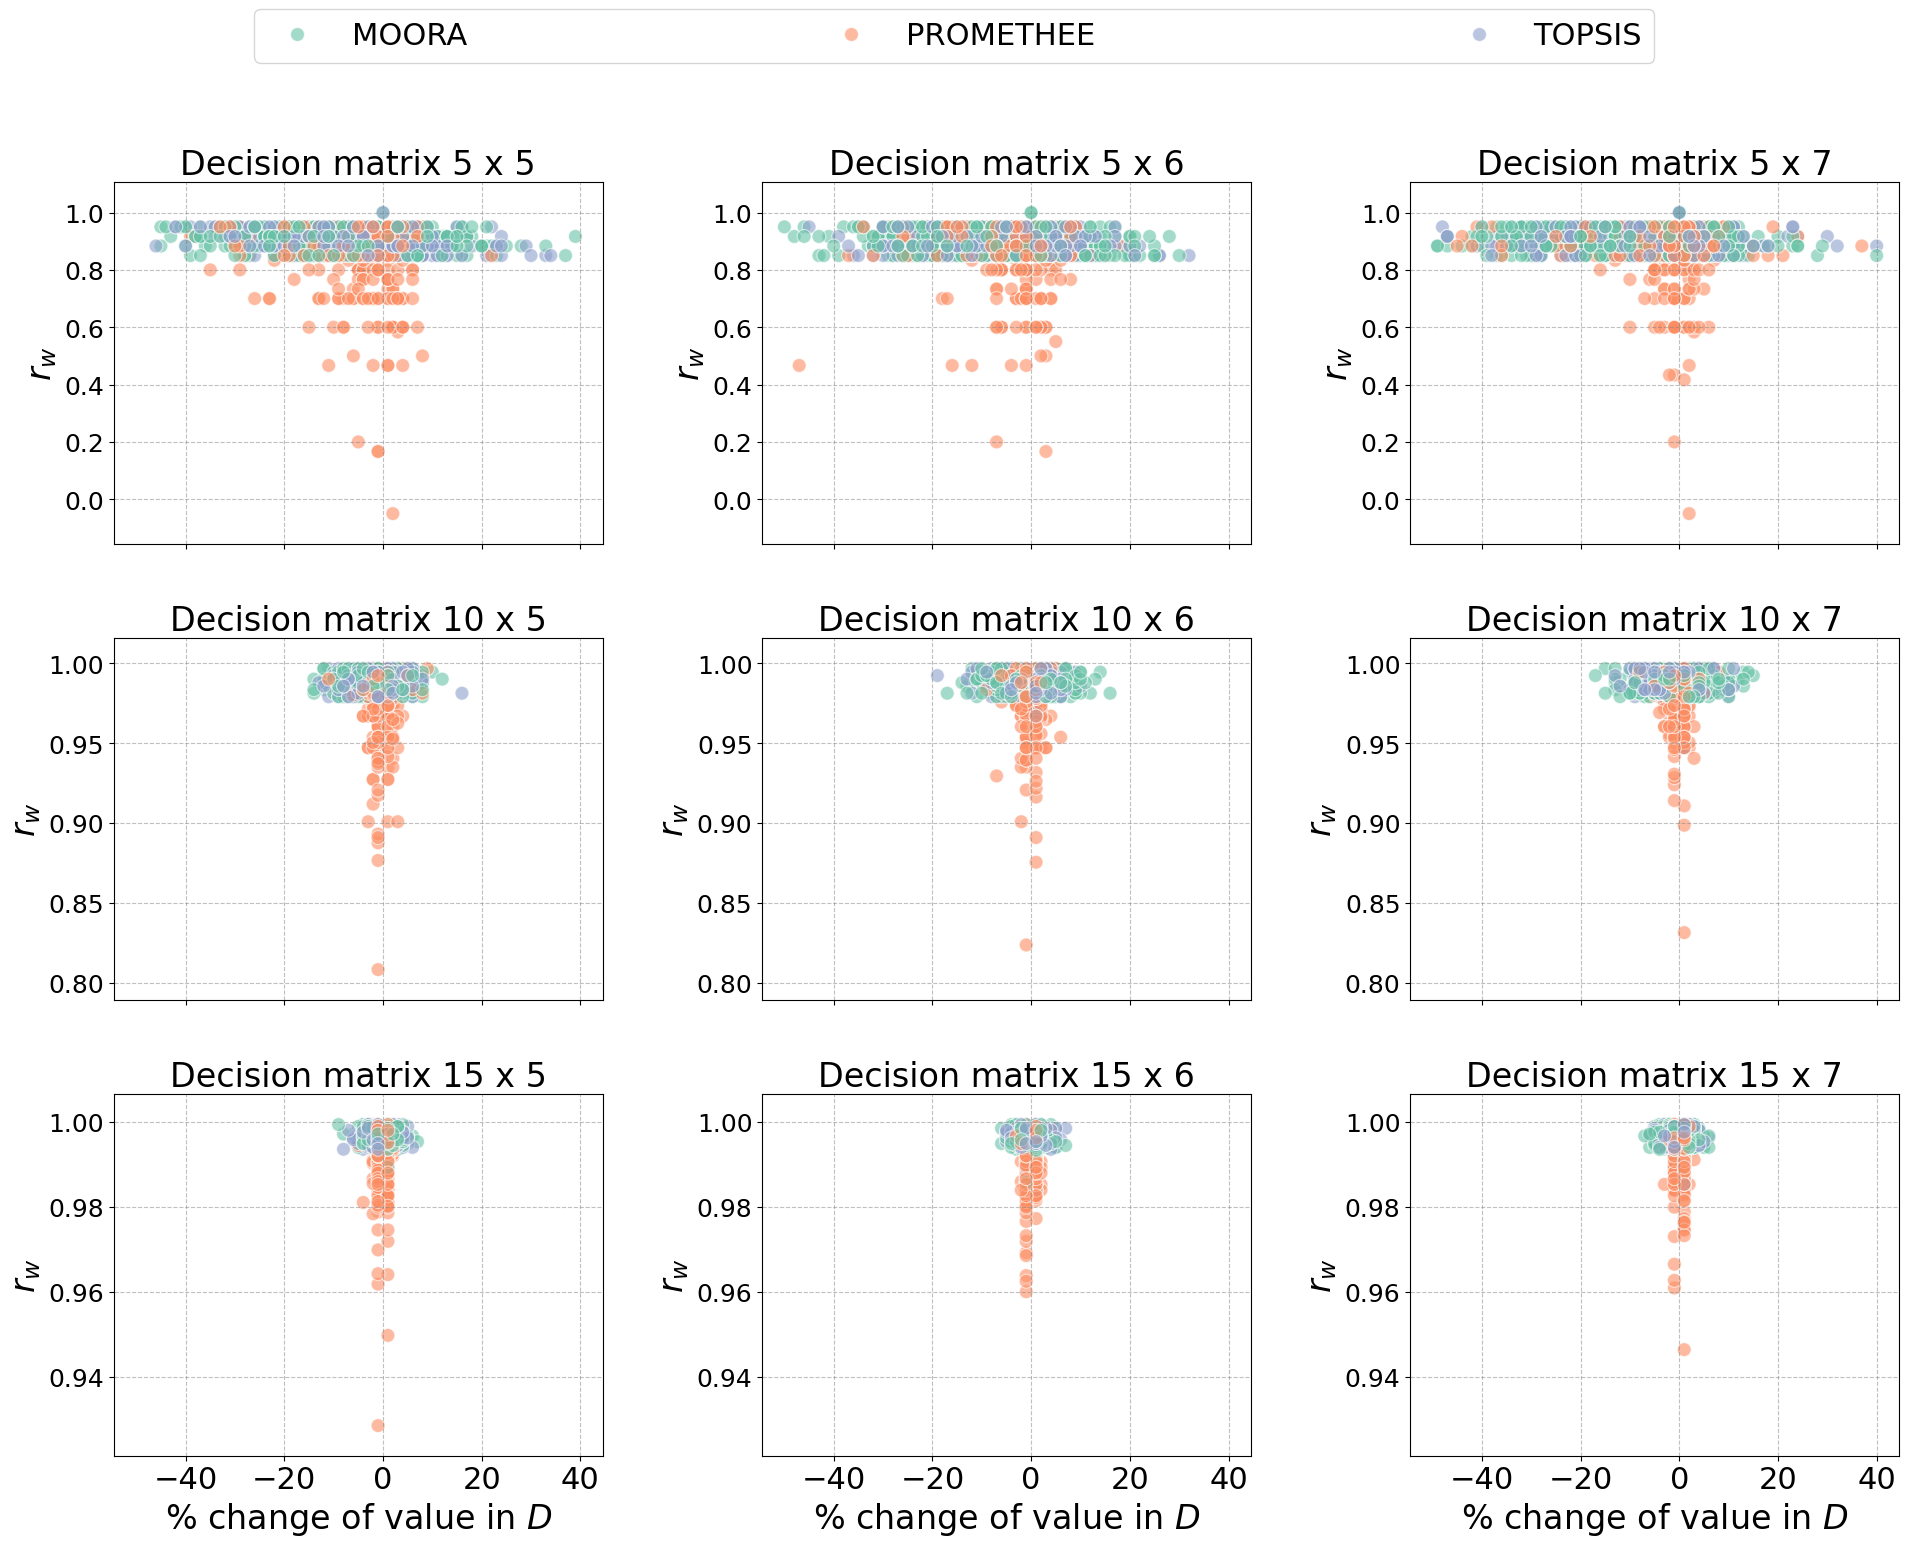

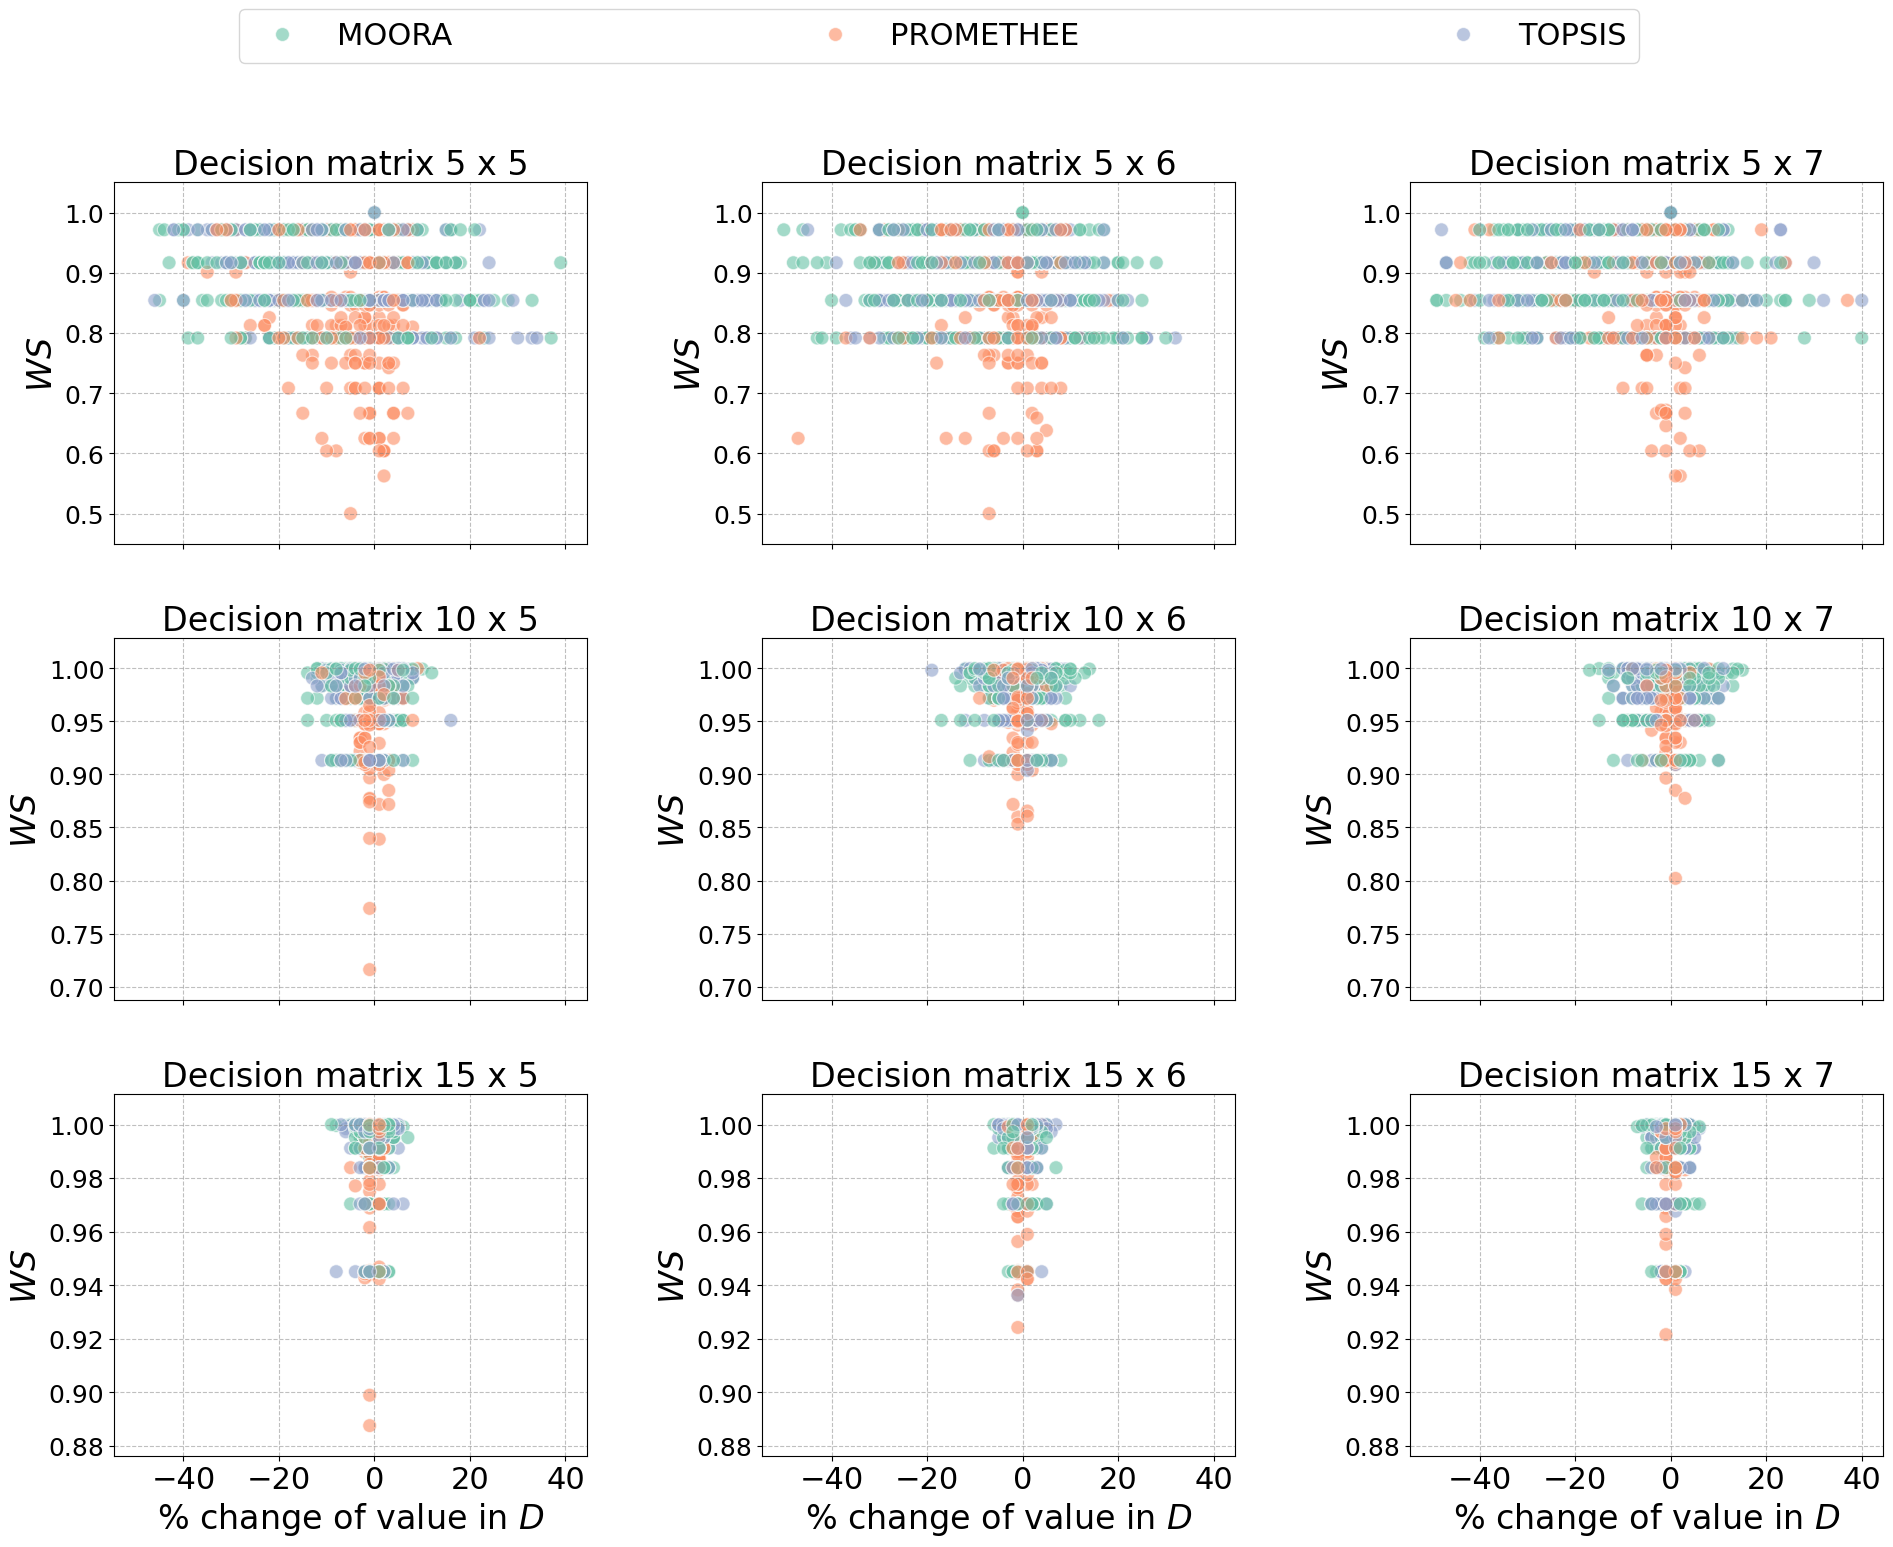

In [41]:
df = exp3_results['modified_global']

unique_alternatives = df['Alternatives'].unique()
unique_criteria = df['Criteria'].unique()

metrics = ['rw', 'WS']
labels = ['$r_w$', '$WS$']

for metric, label in zip(metrics, labels):
    fig, axes = plt.subplots(
        len(unique_alternatives), len(unique_criteria),
        figsize=(20, 15),
        sharex=True, sharey=False
    )


    for i, alt in enumerate(unique_alternatives):
        for j, crit in enumerate(unique_criteria):
            subset = df[(df['Alternatives'] == alt) & (df['Criteria'] == crit)]

            ax = axes[i, j]
            sns.scatterplot(
                data=subset,
                x='% change',
                y=metric,
                hue='MCDA Method',
                palette='Set2',
                ax=ax,
                s=100,
                alpha=0.6
            )

            ax.set_title(f'Decision matrix {alt} x {crit}', fontsize=24)
            ax.set_xlabel('% change of value in $D$', fontsize=24)
            ax.set_ylabel(label, fontsize=24)

            ax.tick_params(axis='y', labelsize=18)
            ax.tick_params(axis='x', labelsize=22)
            ax.legend_.remove()

            ax.grid(axis='both', linestyle='--', color='grey', alpha=0.5)
        
        row_data = df[df['Alternatives'] == alt][metric]
        y_min, y_max = row_data.min(), row_data.max()
        y_padding = (y_max - y_min) * 0.1 
        for ax in axes[i]:
            ax.set_ylim(y_min - y_padding, y_max + y_padding)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0.15, 1.02, 0.7, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, fontsize=22)

    plt.tight_layout(pad=4.0) 
    plt.savefig(f'img/exp3/{metric}_grid_scatter.pdf', bbox_inches='tight')
    plt.savefig(f'img/exp3/{metric}_grid_scatter.png')
    plt.show()
    plt.close()

### KDE for different dimensionalities in simulation runs

c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is

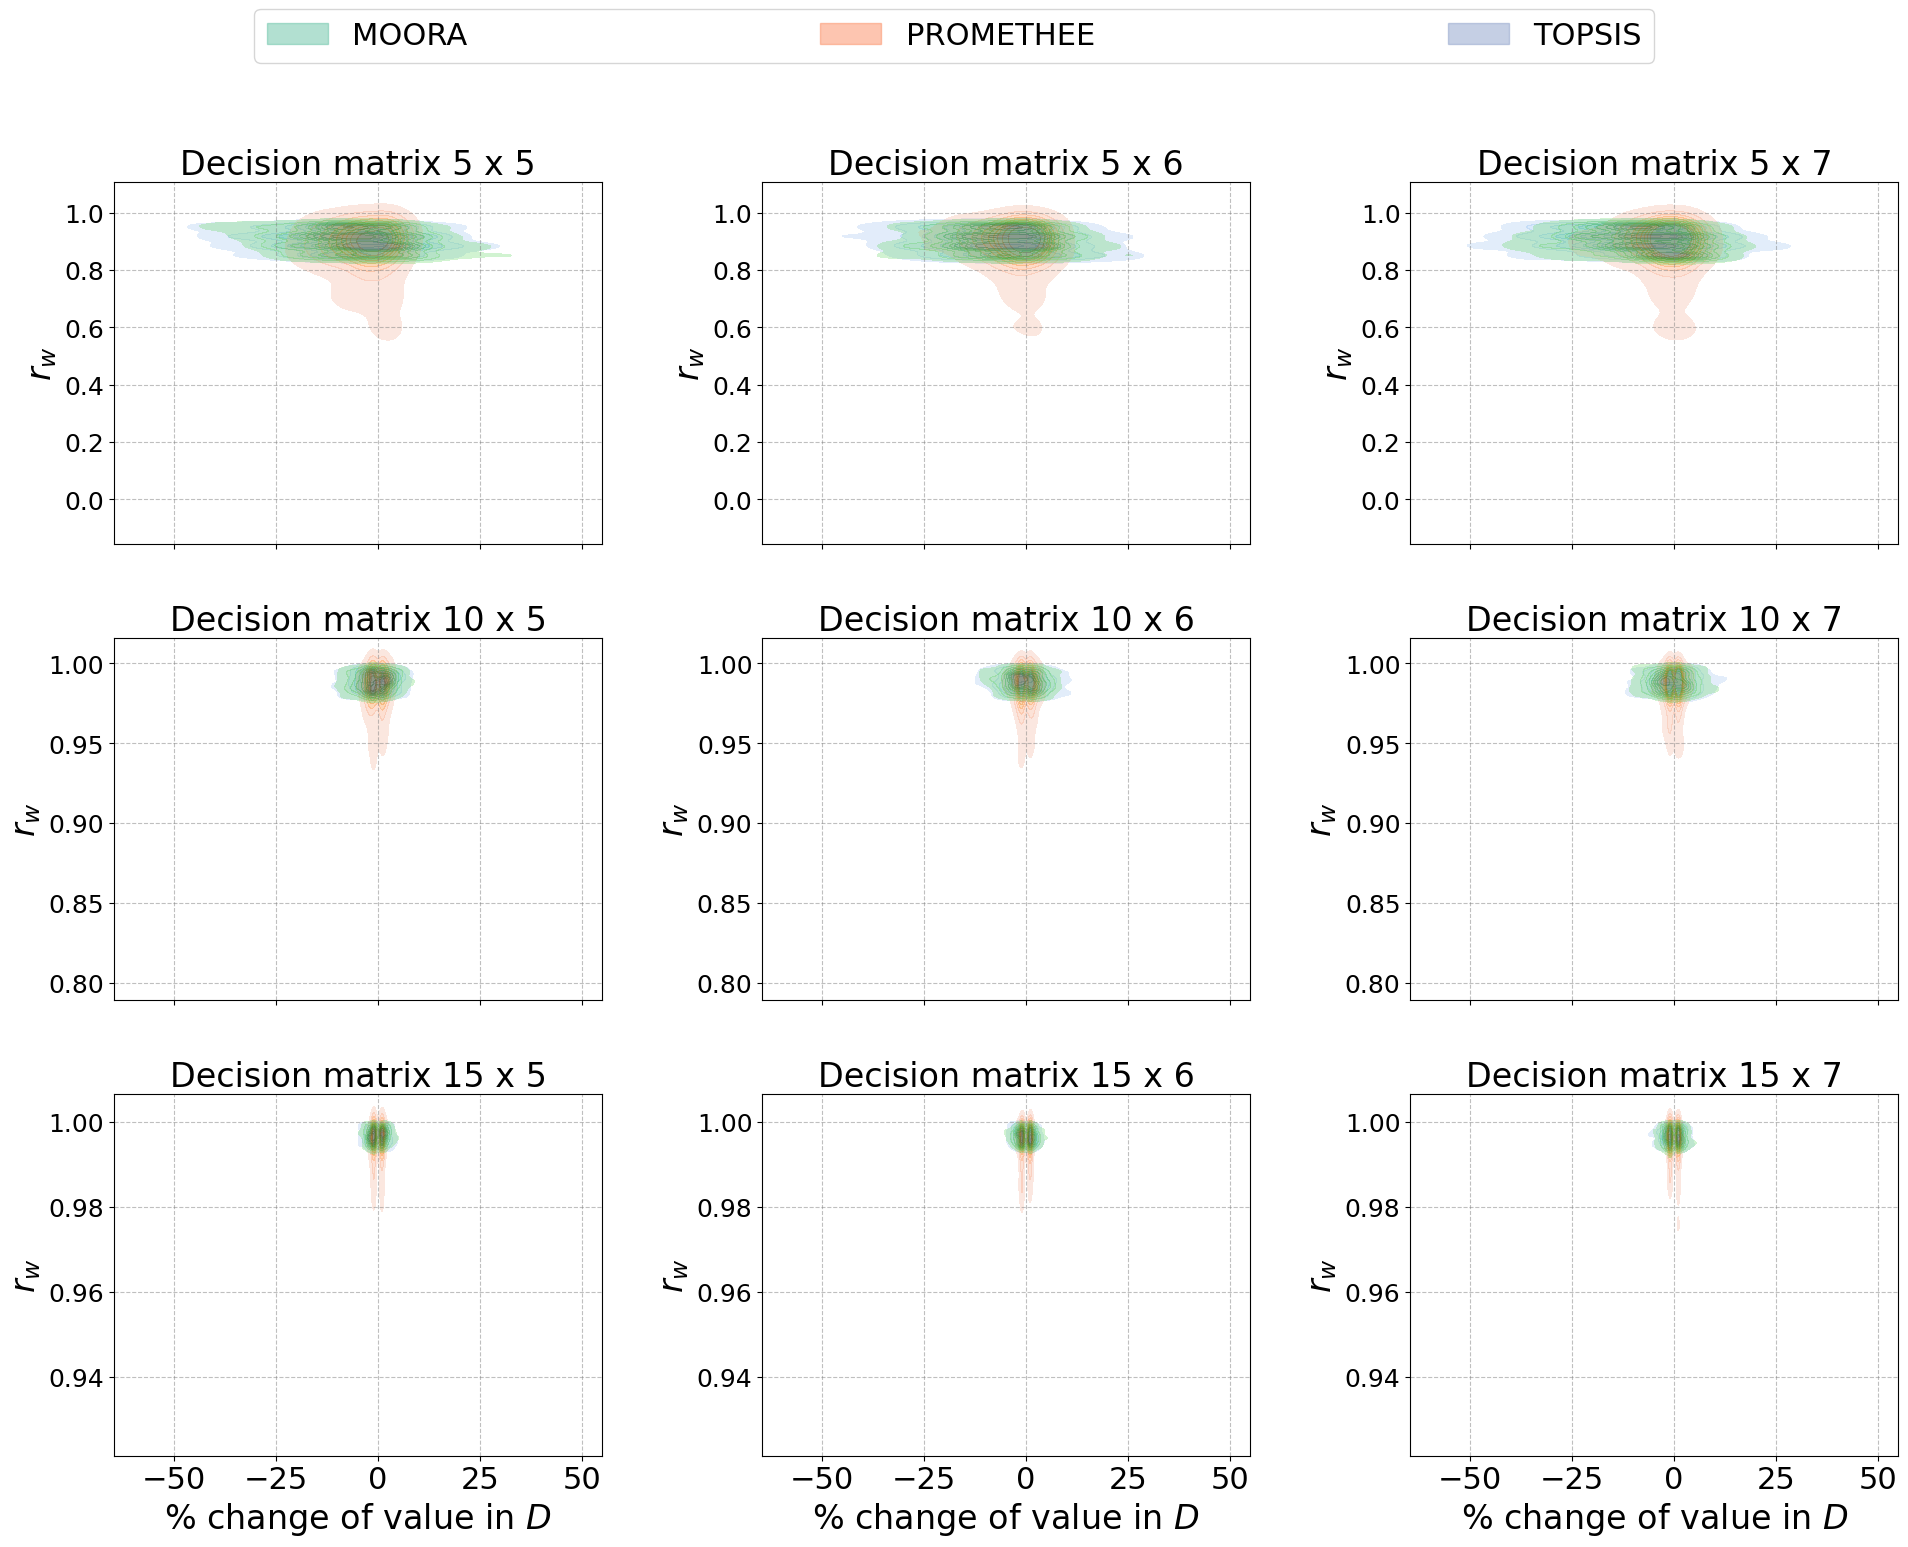

c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is

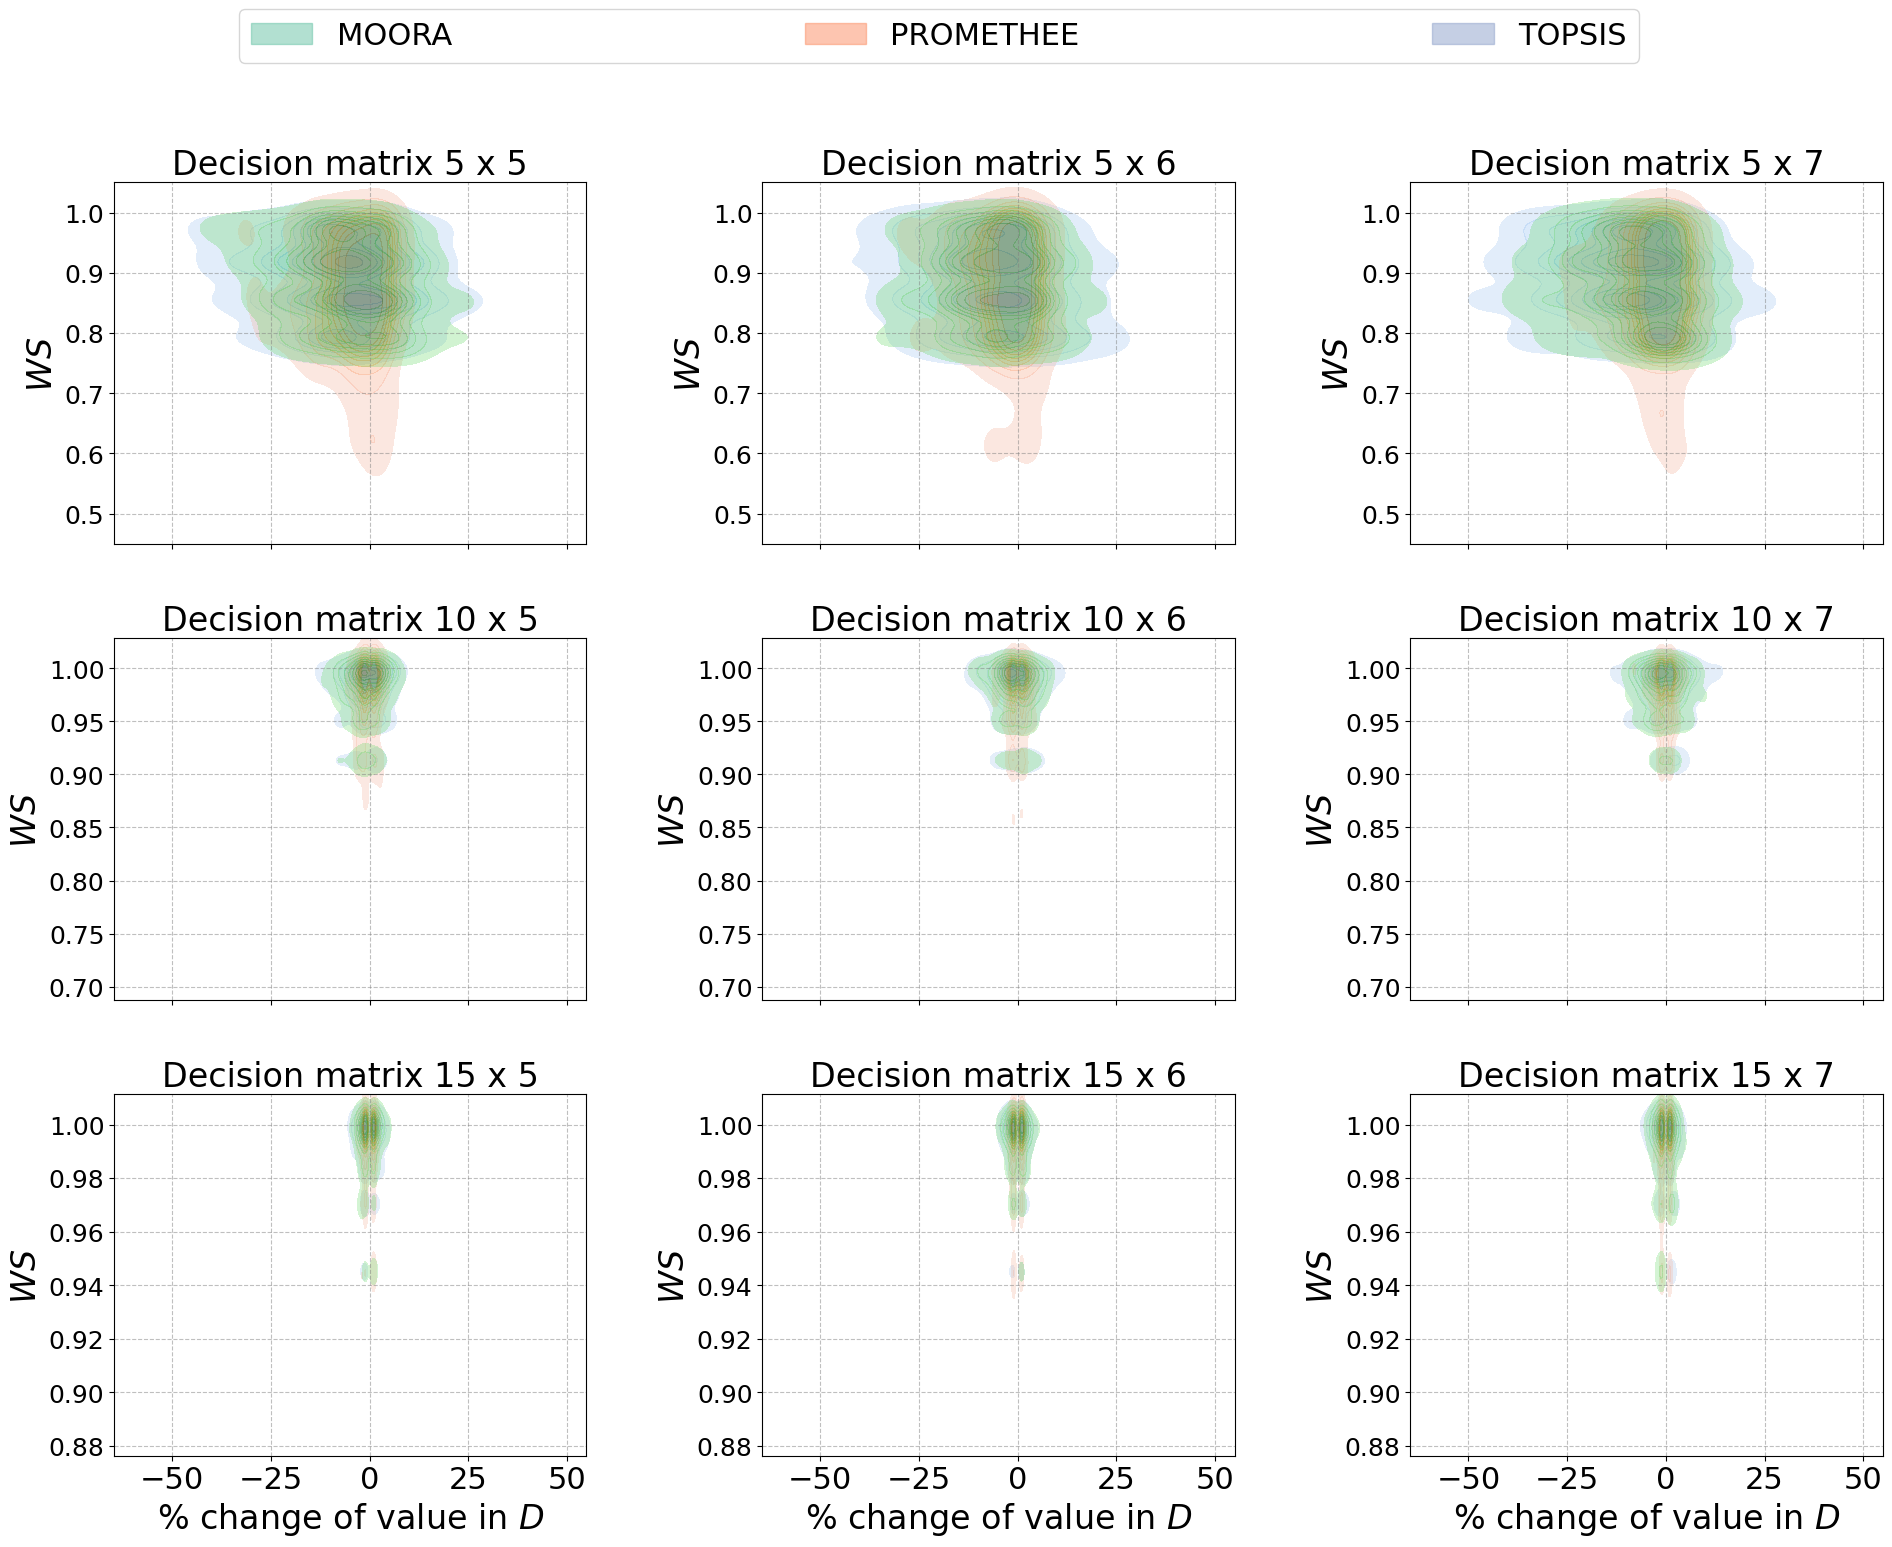

In [21]:
df = exp3_results['modified_global']

unique_alternatives = df['Alternatives'].unique()
unique_criteria = df['Criteria'].unique()

metrics = ['rw', 'WS']
labels = ['$r_w$', '$WS$']

mcda_methods = df["MCDA Method"].unique()
palette = sns.color_palette("Set2", len(mcda_methods))
method_colors = dict(zip(mcda_methods, palette))

alpha_value = 0.5
method_colors_alpha = {method: (*color, alpha_value) for method, color in method_colors.items()}

for metric, label in zip(metrics, labels):
    fig, axes = plt.subplots(
        len(unique_alternatives), len(unique_criteria),
        figsize=(20, 15),
        sharex=True, sharey=False
    )

    for i, alt in enumerate(unique_alternatives):
        for j, crit in enumerate(unique_criteria):
            subset = df[(df['Alternatives'] == alt) & (df['Criteria'] == crit)]

            ax = axes[i, j]
            sns.kdeplot(
                data=subset, x="% change", y=metric,
                hue="MCDA Method", fill=True, alpha=0.3, levels=10, linewidths=0, ax=ax
            )

            scatter = sns.scatterplot(
                data=subset, x="% change", y=metric,
                hue="MCDA Method", style="MCDA Method", palette="Set2", ax=ax, alpha=0
            )

            ax.set_title(f'Decision matrix {alt} x {crit}', fontsize=24)
            ax.set_xlabel('% change of value in $D$', fontsize=24)
            ax.set_ylabel(label, fontsize=24)

            ax.tick_params(axis='y', labelsize=18)
            ax.tick_params(axis='x', labelsize=22)
            ax.legend_.remove()

            ax.grid(axis='both', linestyle='--', color='grey', alpha=0.5)
        
        row_data = df[df['Alternatives'] == alt][metric]
        y_min, y_max = row_data.min(), row_data.max()
        y_padding = (y_max - y_min) * 0.1 
        for ax in axes[i]:
            ax.set_ylim(y_min - y_padding, y_max + y_padding)

    legend_patches = [Patch(color=method_colors_alpha[method], label=method) for method in mcda_methods]
    fig.legend(handles=legend_patches, bbox_to_anchor=(0.15, 1.02, 0.7, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, fontsize=22)

    plt.tight_layout(pad=4.0) 
    plt.savefig(f'img/exp3/exp3_{metric}_grid_kde.pdf', bbox_inches='tight')
    plt.savefig(f'img/exp3/exp3_{metric}_grid_kde.png')
    plt.show()
    plt.close()

